# Analyse re- and upskilling opportunities for all mining-related occupations
Felix Zaussinger | 15.06.2021

## Core Analysis Goal(s)
1. Map transition pathways for occupations likely affected by coal phase-outs by
using mining-related occupations as a proxy.

## Key Insight(s)
1.

In [247]:
import os
import sys
import logging
from pathlib import Path

import numpy as np
import scipy as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_context("paper")
sns.set(rc={'figure.figsize': (16, 9.)})
sns.set_style("ticks")

import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

from tqdm import tqdm
from scipy.spatial.distance import pdist, squareform

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Define directory structure

In [248]:
# project directory
abspath = os.path.abspath('')
project_dir = str(Path(abspath).parents[0])

# sub-directories
data_raw = os.path.join(project_dir, "data", "raw")
data_interim = os.path.join(project_dir, "data", "interim")
data_processed = os.path.join(project_dir, "data", "processed")
figure_dir = os.path.join(project_dir, "reports", "figures")

ESCO data set components

In [249]:
occ = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupations_en.csv"))
skill_groups = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skillGroups_en.csv"))
skills = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "skills_en.csv"))
occ_skills_mapping = pd.read_csv(os.path.join(data_raw, "esco", "v1.0.3", "occupationSkillRelations.csv"))

In [283]:
df_metadata = pd.read_csv(
    os.path.join(data_interim, "ESCO_ONET_METADATA.csv"),
    index_col=0
)

df_metadata.greenness_vona_2018 = df_metadata.greenness_vona_2018.fillna(0)

# convert job zone to categorical var
df_metadata.job_zone = pd.Categorical(df_metadata.job_zone, ordered=True)
df_metadata.isco_level_1 = pd.Categorical(df_metadata.isco_level_1, ordered=False)
df_metadata.isco_level_2 = pd.Categorical(df_metadata.isco_level_2, ordered=False)

In [251]:
# nesta report
sim_kanders = np.load(
    os.path.join(data_raw, "mcc_data", "processed", "sim_matrices", "OccupationSimilarity_Combined.npy")
)

np.fill_diagonal(sim_kanders, 0)

## Determine closest matches based on skill similiarity

In [252]:
# source: https://github.com/nestauk/mapping-career-causeways/blob/main/mapping_career_causeways/compare_nodes_utils.py
def find_closest(i, similarity_matrix, df):
    """
    Method for reporting the closest neighbours to a node i given a similarity matrix;
    useful during exploratory data analysis.
    Parameters
    ----------
    i (int OR None):
        Determines for which node where are assessing the closest neighbours;
        if i==None, a random node is chosen.
    similarity_matrix (numpy.ndarray):
        Similarity matrix determining the closeness between each pair of nodes.
    df (pandas.DataFrame):
        Dataframe to be used for reporting the closest neighbours; must have then
        same number of rows as the similarity matrix
    Returns
    -------
    df (pandas.DataFrame):
        The same input dataframe with an added column for similarity values
        between node i and the rest of the nodes, ordered in a descending order
        of similarity.
    """
    if type(i) == type(None):
        i = np.random.randint(similarity_matrix.shape[0])

    most_similar = np.flip(np.argsort(similarity_matrix[i,:]))
    similarity = np.flip(np.sort(similarity_matrix[i,:]))

    df = df.copy().loc[most_similar]
    df['similarity'] = similarity
    return df

## Identify mining-related occupations

In [253]:
# cue 1: in mining-related isco occupation
mining_occupations = [1322, 2146, 3117, 3121, 8111, 9311]
df_metadata["mining_isco"] = df_metadata.isco_level_4.isin(mining_occupations)

In [254]:
# cue 2: mining-related keywords in occupation description
mining_keywords = ["mine", "Mine", "mining", "Mining"]

mining_kw = []
for occ_desc in occ.description:
    mining_kw.append(any(True if kw in occ_desc.split(" ") else False for kw in mining_keywords))

df_metadata["mining_kw"] = mining_kw

df_metadata["is_mining"] = np.logical_or(df_metadata.mining_kw, df_metadata.mining_isco)

In [256]:
# keyword cue yields 31 mining occs, isco cue yields 30
df_metadata.mining_isco.value_counts()
df_metadata.mining_kw.value_counts()

False    2911
True       31
Name: mining_kw, dtype: int64

In [257]:
# subset mining occupations
df_mining_occ = df_metadata["is_mining"]
df_mining_occ

,id,concept_uri,preferred_label,isco_level_4,onet_code,onet_occupation,isco_level_1,isco_level_2,isco_level_3,occupation_type,n_new_green_tasks,n_existing_green_tasks,n_non_green_tasks,greenness_vona_2018,total_paid_hours,annual_earnings,employment_share,employment_count,job_zone,education_level,related_work_experience,on_the_job_training,skill_level_ilo,new_jobs_absorbing_ilo_2030_es,new_jobs_net_ilo_2030_es,jobs_lost_net_ilo_2030_es,jobs_lost_reallocated_ilo_2030_es,net_change_ilo_2030_es,new_jobs_absorbing_ilo_2030_ce,new_jobs_net_ilo_2030_ce,jobs_lost_net_ilo_2030_ce,jobs_lost_reallocated_ilo_2030_ce,net_change_ilo_2030_ce,mining_isco,mining_kw,is_mining
14,14,http://data.europa.eu/esco/occupation/00ab29a3...,mine surveyor,2165,17-1022.00,surveyors,2,21,216,Non Green,NaN,NaN,NaN,0.000000,36.730932,32009.151220,NaN,NaN,4.0,4.8069,6.6324,5.4998,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,True,True
52,52,http://data.europa.eu/esco/occupation/03b2f112...,quarry engineer,2146,17-2151.00,"mining and geological engineers, including min...",2,21,214,Non Green,NaN,NaN,NaN,0.000000,40.178069,36554.033333,0.000359,11552.0,4.0,6.2073,7.7984,5.4027,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,True,False,True
82,82,http://data.europa.eu/esco/occupation/0633ec3f...,oil and gas production manager,1322,17-2151.00,"mining and geological engineers, including min...",1,13,132,Non Green,NaN,NaN,NaN,0.000000,39.344262,45669.058252,NaN,NaN,4.0,6.2073,7.7984,5.4027,H,136000.0,323000.0,-36000.0,-136000.0,287000.0,1095000.0,143000.0,-1110000.0,-1095000.0,-967000.0,True,False,True
83,83,http://data.europa.eu/esco/occupation/06351e17...,metallurgical technician,3117,17-2131.00,materials engineers,3,31,311,Non Green,NaN,NaN,NaN,0.000000,38.488444,27504.553459,0.000211,6784.0,4.0,7.3071,6.2564,4.0772,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,True,False,True
209,209,http://data.europa.eu/esco/occupation/107d21c6...,mine manager,1322,17-2151.00,"mining and geological engineers, including min...",1,13,132,Non Green,NaN,NaN,NaN,0.000000,39.344262,45669.058252,0.002476,79608.0,4.0,6.2073,7.7984,5.4027,H,136000.0,323000.0,-36000.0,-136000.0,287000.0,1095000.0,143000.0,-1110000.0,-1095000.0,-967000.0,True,True,True
284,284,http://data.europa.eu/esco/occupation/1790c821...,mine geologist,2114,19-2042.00,"geoscientists, except hydrologists and geograp...",2,21,211,Green Enhanced Skills,12.0,3.0,16.0,0.937500,37.800000,42983.000000,NaN,NaN,4.0,7.5426,5.6671,4.3328,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,True,True
429,429,http://data.europa.eu/esco/occupation/23993e79...,mine shift manager,3121,47-1011.00,first-line supervisors of construction trades ...,3,31,312,Non Green,NaN,NaN,NaN,0.000000,40.463750,24548.793651,NaN,NaN,3.0,2.8266,7.5779,6.2029,H,748000.0,528000.0,206000.0,-748000.0,734000.0,3042000.0,1225000.0,-965000.0,-3042000.0,260000.0,True,True,True
486,486,http://data.europa.eu/esco/occupation/27eb624c...,chemical metallurgist,2146,17-2131.00,materials engineers,2,21,214,Non Green,NaN,NaN,NaN,0.000000,40.178069,36554.033333,NaN,NaN,4.0,7.3071,6.2564,4.0772,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,True,False,True
609,609,http://data.europa.eu/esco/occupation/32548f7e...,environmental mining engineer,2143,17-2081.00,environmental engineers,2,21,214,Green Enhanced Skills,3.0,25.0,0.0,1.000000,40.796026,34463.526055,NaN,NaN,5.0,7.1481,5.5545,4.7029,H,500000.0,263000.0,253000.0,-500000.0,516000.0,1379000.0,1274000.0,-397000.0,-1379000.0,877000.0,False,True,True
661,661,http://data.europa.eu/esco/occupation/364e61ab...,driller,8111,47-5021.00,"earth drillers, except oil and gas",8,81,811,Non Green,NaN,NaN,NaN,0.000000,41.125041,28282.005769,0.000021,680.0,2.0,1.9706,4.5053,

## Iterate over mining occupations and identify transition options

In [259]:
transition_numbers = {}
df_occ = pd.DataFrame(occ.conceptUri.values, columns=["conceptUri"])

# iterate over mining occupations
for i in df_mining_occ.id:

    # find closest occupations
    sim_ranking = find_closest(
        i=i,
        similarity_matrix=sim_kanders,
        df=df_occ
    )

    # print source occupation
    source_occ = df_metadata.loc[i, :]
    print("Source occupation: {}".format(source_occ.preferred_label))

    # merge metadata
    result = pd.merge(
        sim_ranking,
        df_metadata[[
            "concept_uri",
            "preferred_label",
            "greenness_vona_2018",
            "annual_earnings",
            "is_mining",
        ]],
        left_on="conceptUri",
        right_on="concept_uri",
        how="left"
    ).drop(columns=["concept_uri"], axis=1)

    # add metadata
    result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings
    result["is_viable"] = result.similarity >= 0.3
    result["is_highly_viable"] = result.similarity >= 0.4
    result["is_desirable"] = result.is_viable & (result.earnings_ratio >= 0.75)
    result["is_highly_desirable"] = result.is_highly_viable & (result.earnings_ratio >= 0.75)
    result["is_green"] = result.greenness_vona_2018 > 0
    result["is_neutral"] = (result.greenness_vona_2018 == 0) & (result.is_mining == False)

    # highly viable transitions
    result["is_highly_viable_mining"] = (result.similarity >= 0.4) & (result.is_mining == True)
    result["is_highly_viable_neutral"] = (result.similarity >= 0.4) & (result.is_neutral == True)
    result["is_highly_viable_green"] = (result.similarity >= 0.4) & (result.is_green == True)

    # desirable transitions
    result["is_desirable_mining"] = result.is_desirable & (result.is_mining == True)
    result["is_desirable_neutral"] = result.is_desirable & (result.is_neutral == True)
    result["is_desirable_green"] = result.is_desirable & (result.is_green == True)

    # highly desirable transitions
    result["is_highly_desirable_mining"] = result.is_highly_desirable & (result.is_mining == True)
    result["is_highly_desirable_neutral"] = result.is_highly_desirable & (result.is_neutral == True)
    result["is_highly_desirable_green"] = result.is_highly_desirable & (result.is_green == True)

    # subset to viable transitions
    result_subset = result[result.is_viable == True]

    # subset to boolean cols
    boolean_cols = [
        'is_viable', 'is_highly_viable', 'is_desirable', 'is_highly_desirable',
        'is_green', 'is_neutral', 'is_mining',
        'is_highly_viable_mining', 'is_highly_viable_neutral', 'is_highly_viable_green',
        'is_desirable_mining', 'is_desirable_neutral', 'is_desirable_green',
        'is_highly_desirable_mining', 'is_highly_desirable_neutral', 'is_highly_desirable_green'
    ]

    # subset to viable transitions only
    result_subset_bools = result_subset[boolean_cols]

    # count True's per boolean column
    s_sum = result_subset_bools.sum()

    transition_numbers[i] = s_sum

# to df
df_transition_numbers = pd.DataFrame.from_dict(transition_numbers).transpose()
df_transition_numbers_labelled = pd.concat(
    [df_transition_numbers, df_mining_occ[["preferred_label"]]], axis=1
)

Source occupation: mine surveyor
Source occupation: quarry engineer
Source occupation: oil and gas production manager
Source occupation: metallurgical technician
Source occupation: mine manager
Source occupation: mine geologist
Source occupation: mine shift manager
Source occupation: chemical metallurgist
Source occupation: environmental mining engineer
Source occupation: driller
Source occupation: drilling engineer
Source occupation: explosives engineer
Source occupation: underground heavy equipment operator
Source occupation: dewatering technician
Source occupation: liquid fuel engineer
Source occupation: surface miner
Source occupation: underground miner
Source occupation: process metallurgist
Source occupation: technical sales representative in mining and construction machinery
Source occupation: mine supervisor
Source occupation: mine development engineer
Source occupation: mineral processing engineer
Source occupation: hydrogeologist
Source occupation: petroleum engineer
Source o

## Visualise transition numbers for different categories

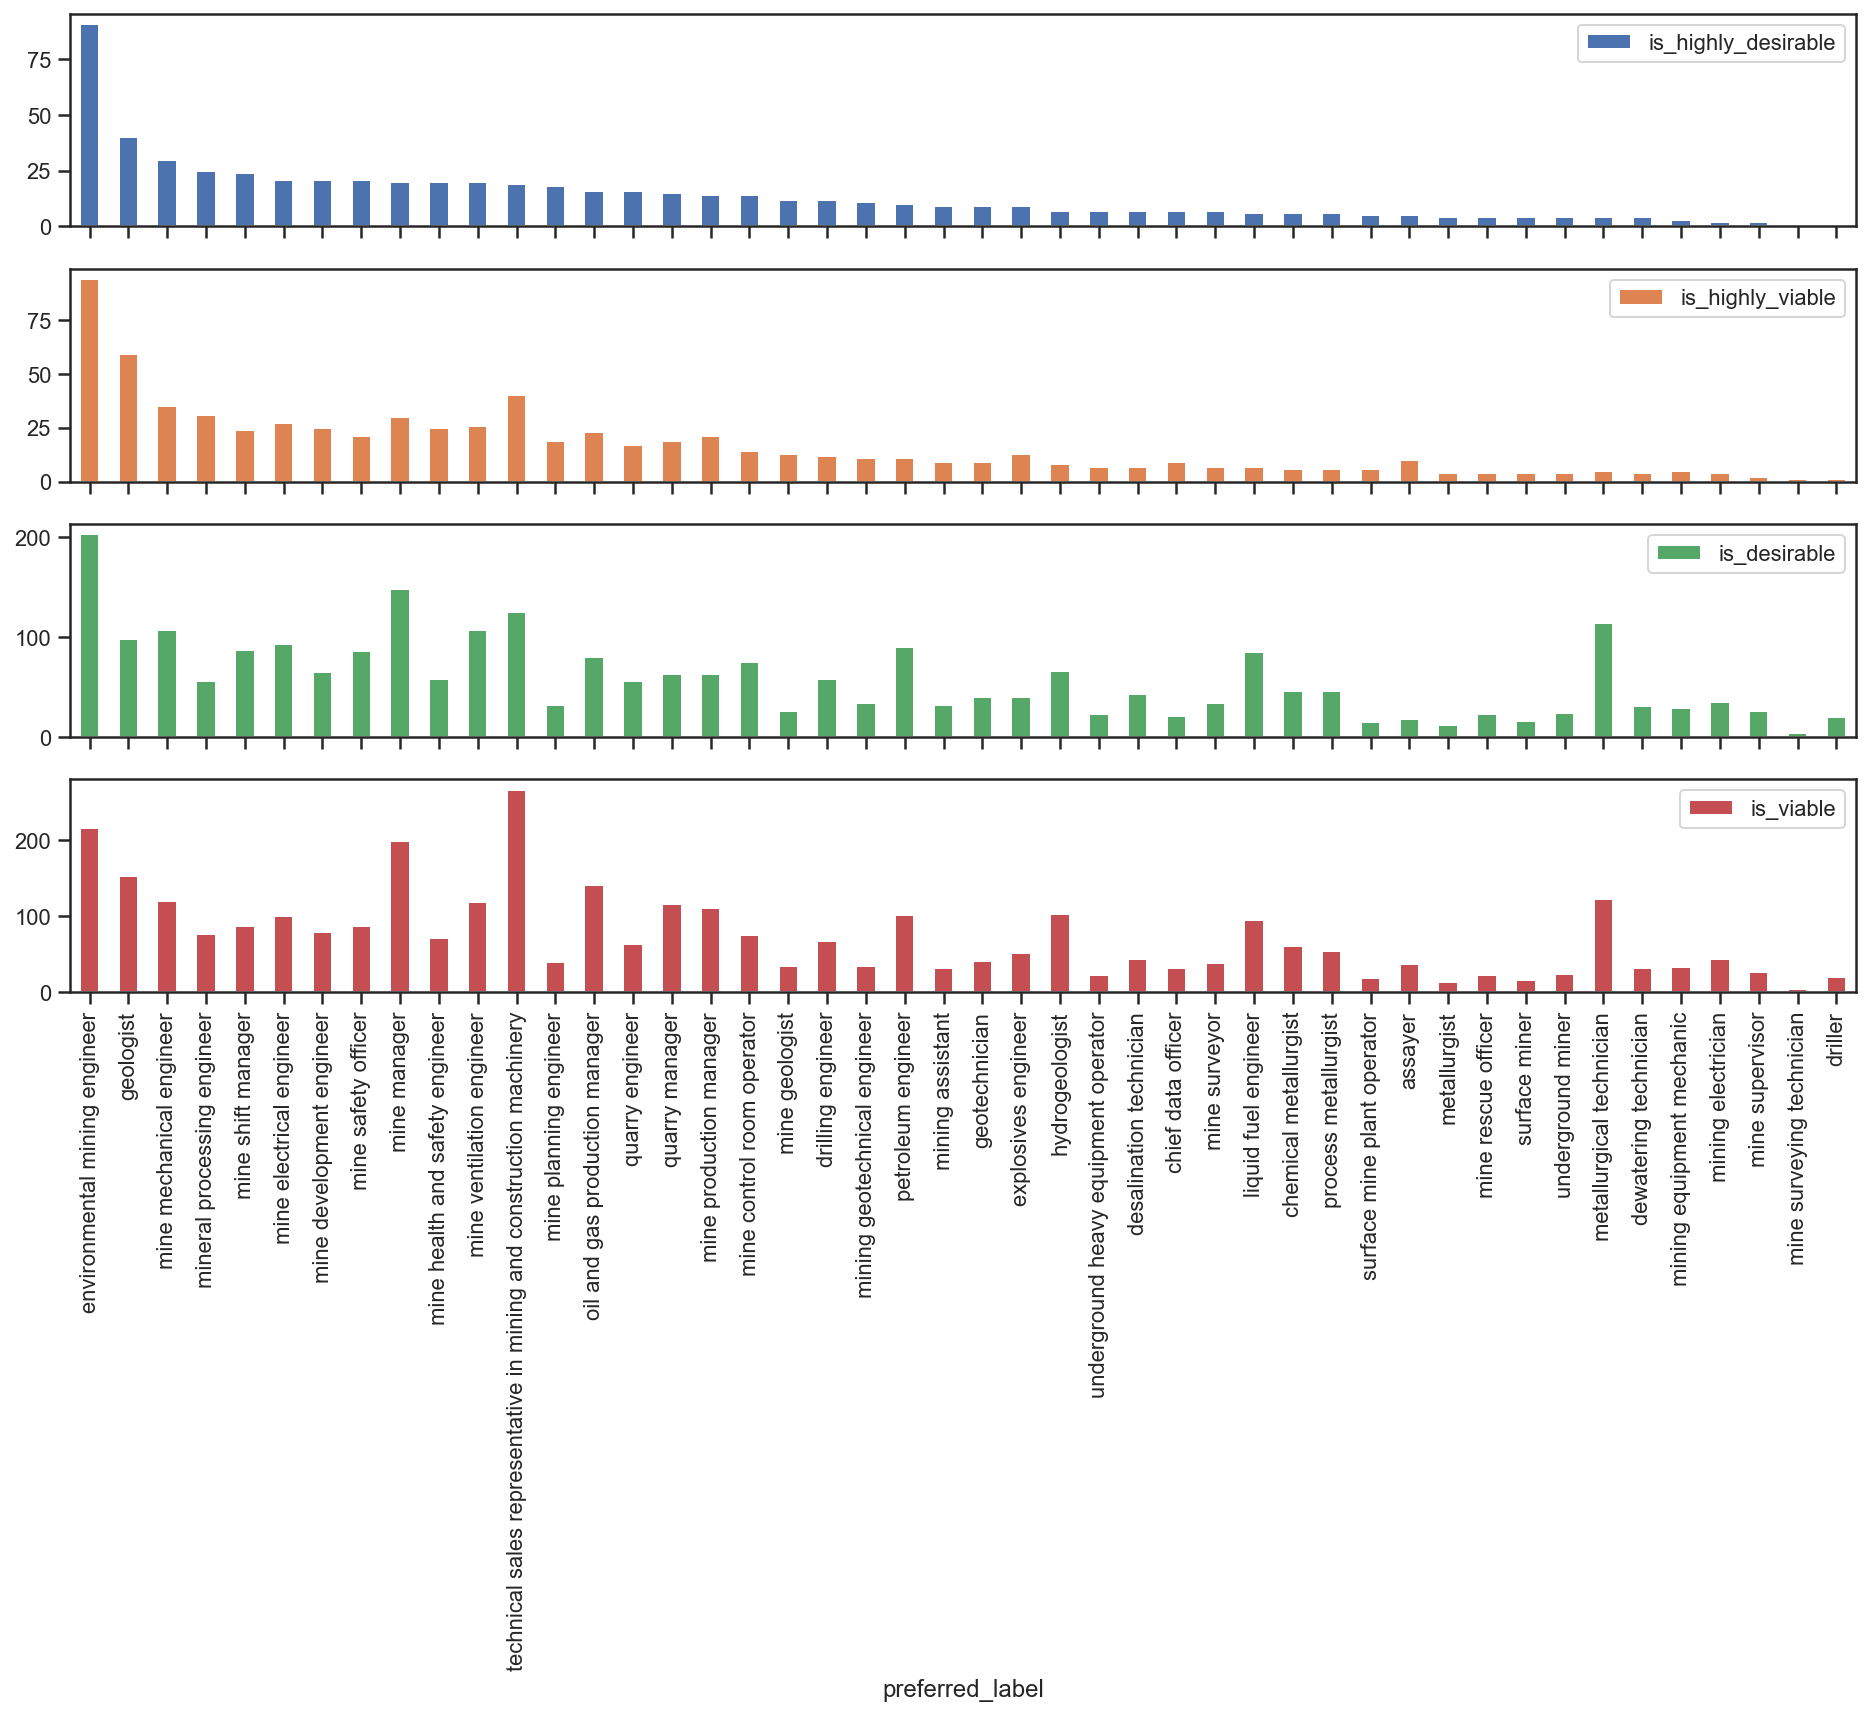

In [260]:
(df_transition_numbers_labelled
 .sort_values("is_highly_desirable", ascending=False)[['is_highly_desirable', 'is_highly_viable', 'is_desirable', 'is_viable', "preferred_label"]]
 .plot.bar(
    x="preferred_label",
    subplots=True,
    sharey=False,
    title=['', '', '', '']
 )
)

plt.savefig(
    os.path.join(figure_dir, "n_transitions_overview.png"),
    dpi=150,
    bbox_inches="tight"
)

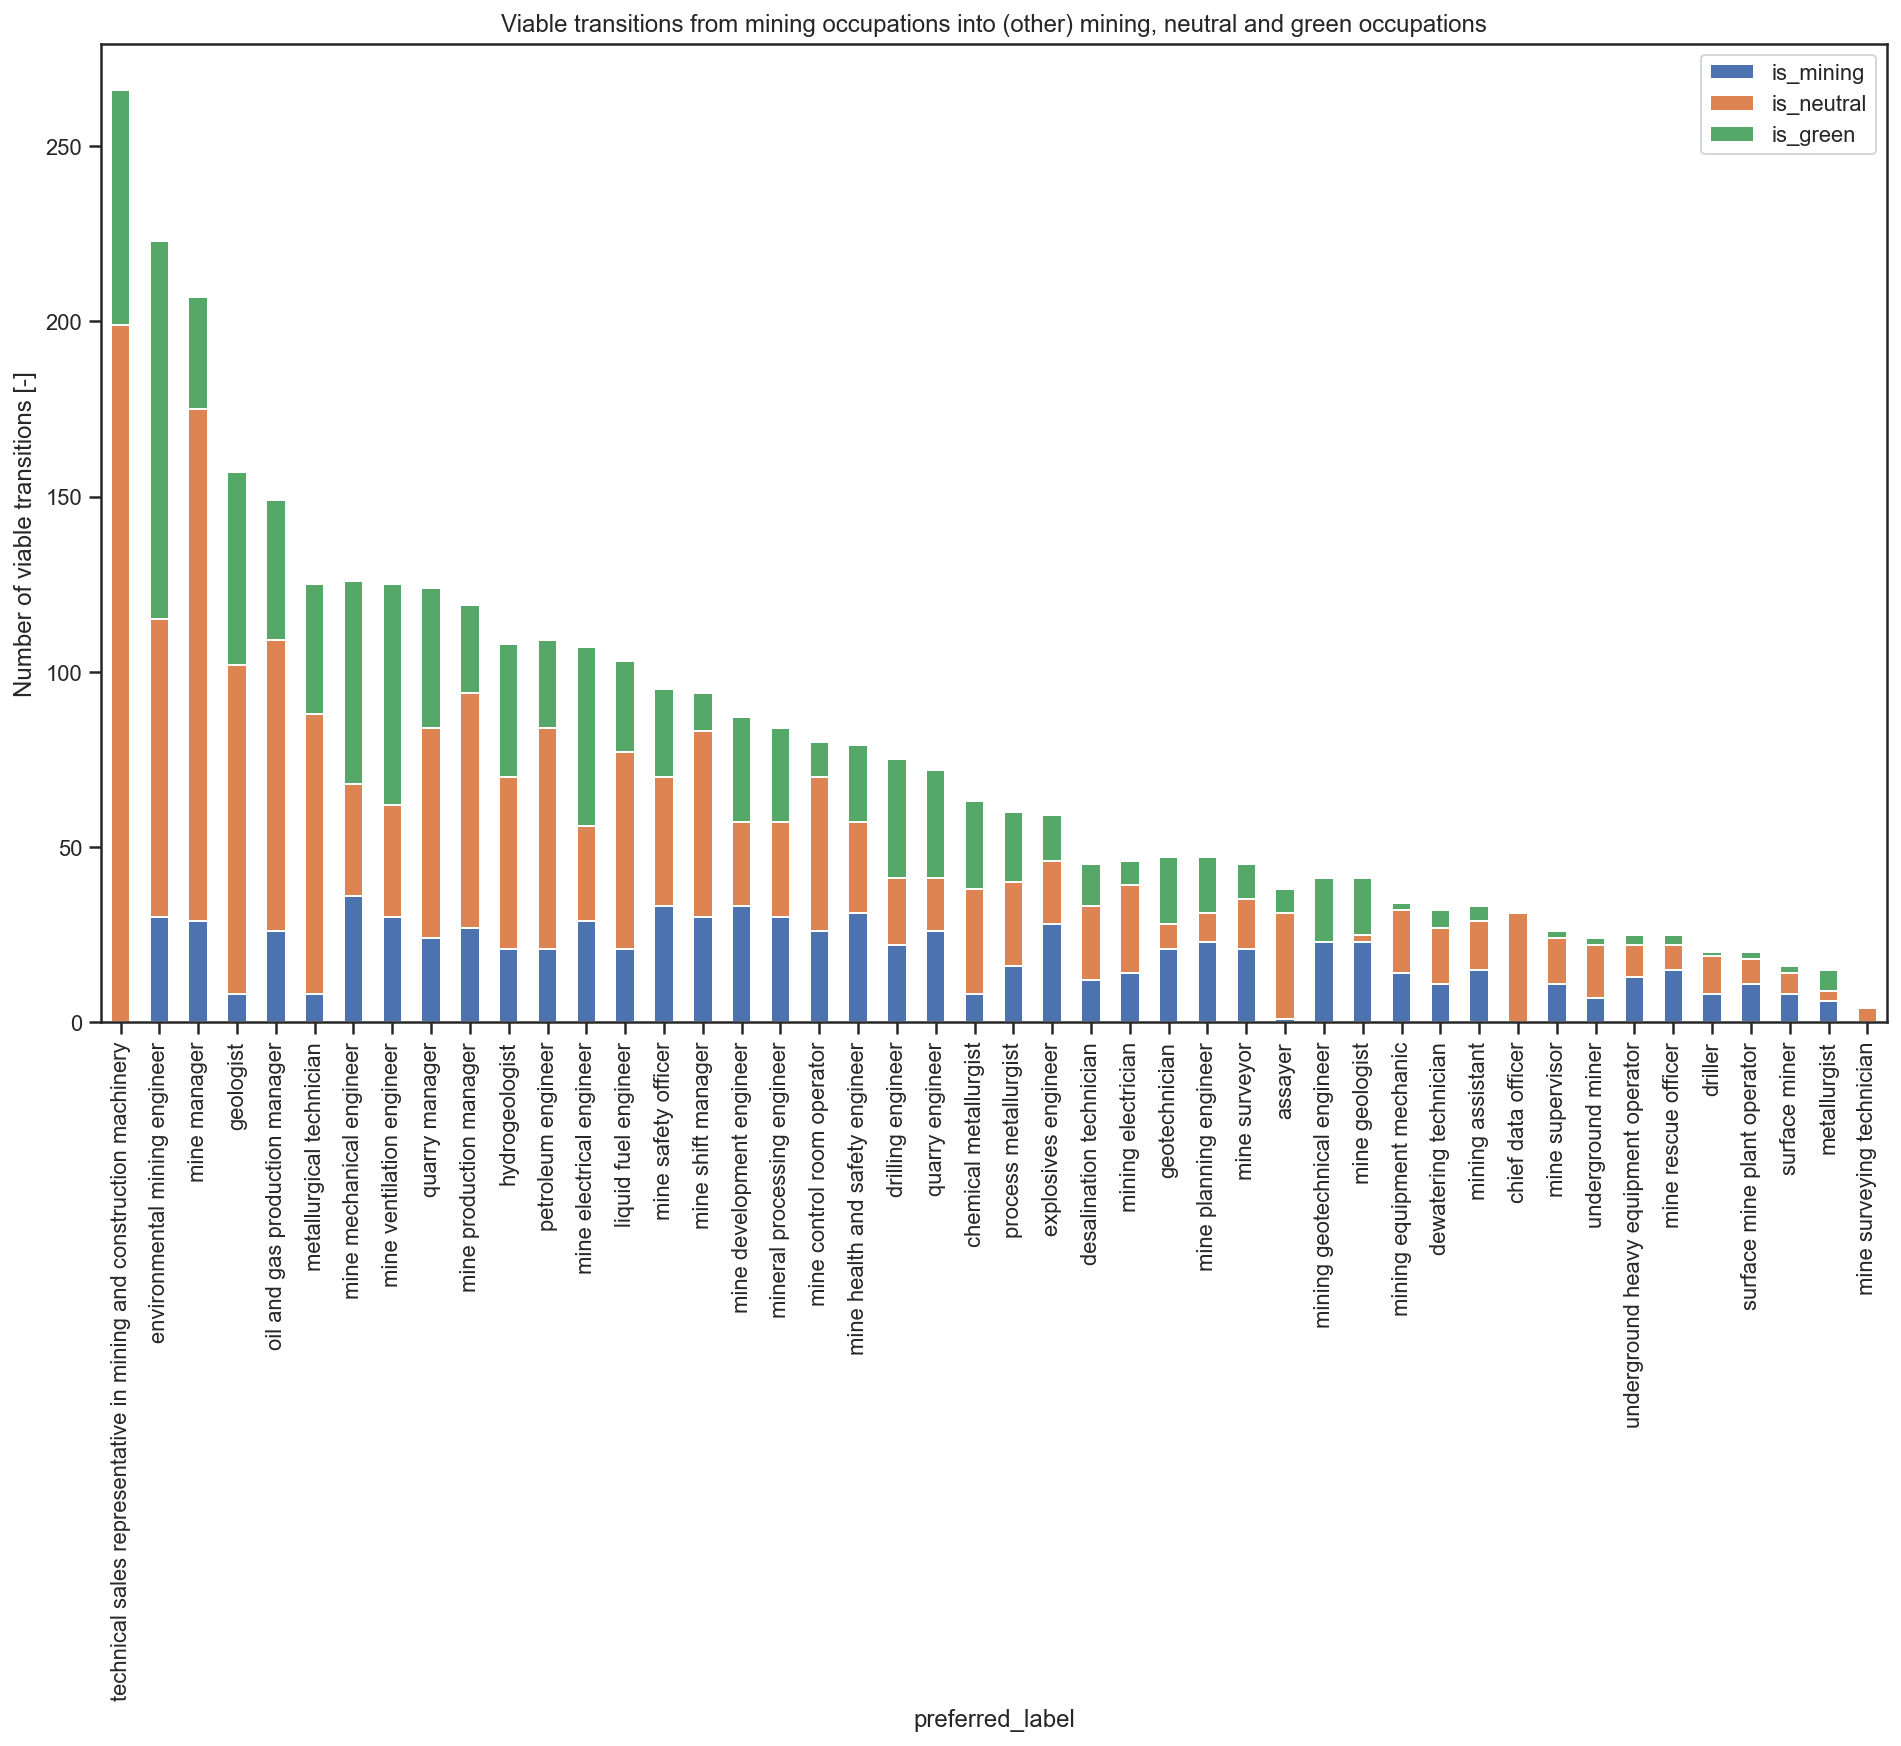

In [261]:
# viable transitions
(df_transition_numbers_labelled
 .sort_values("is_viable", ascending=False)[["is_mining", "is_neutral", "is_green", "preferred_label"]]
 .plot.bar(
    x="preferred_label",
    sharey=False,
    stacked=True,
    title="Viable transitions from mining occupations into (other) mining, neutral and green occupations",
    ylabel="Number of viable transitions [-]"
 )
)

plt.savefig(
    os.path.join(figure_dir, "n_viable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

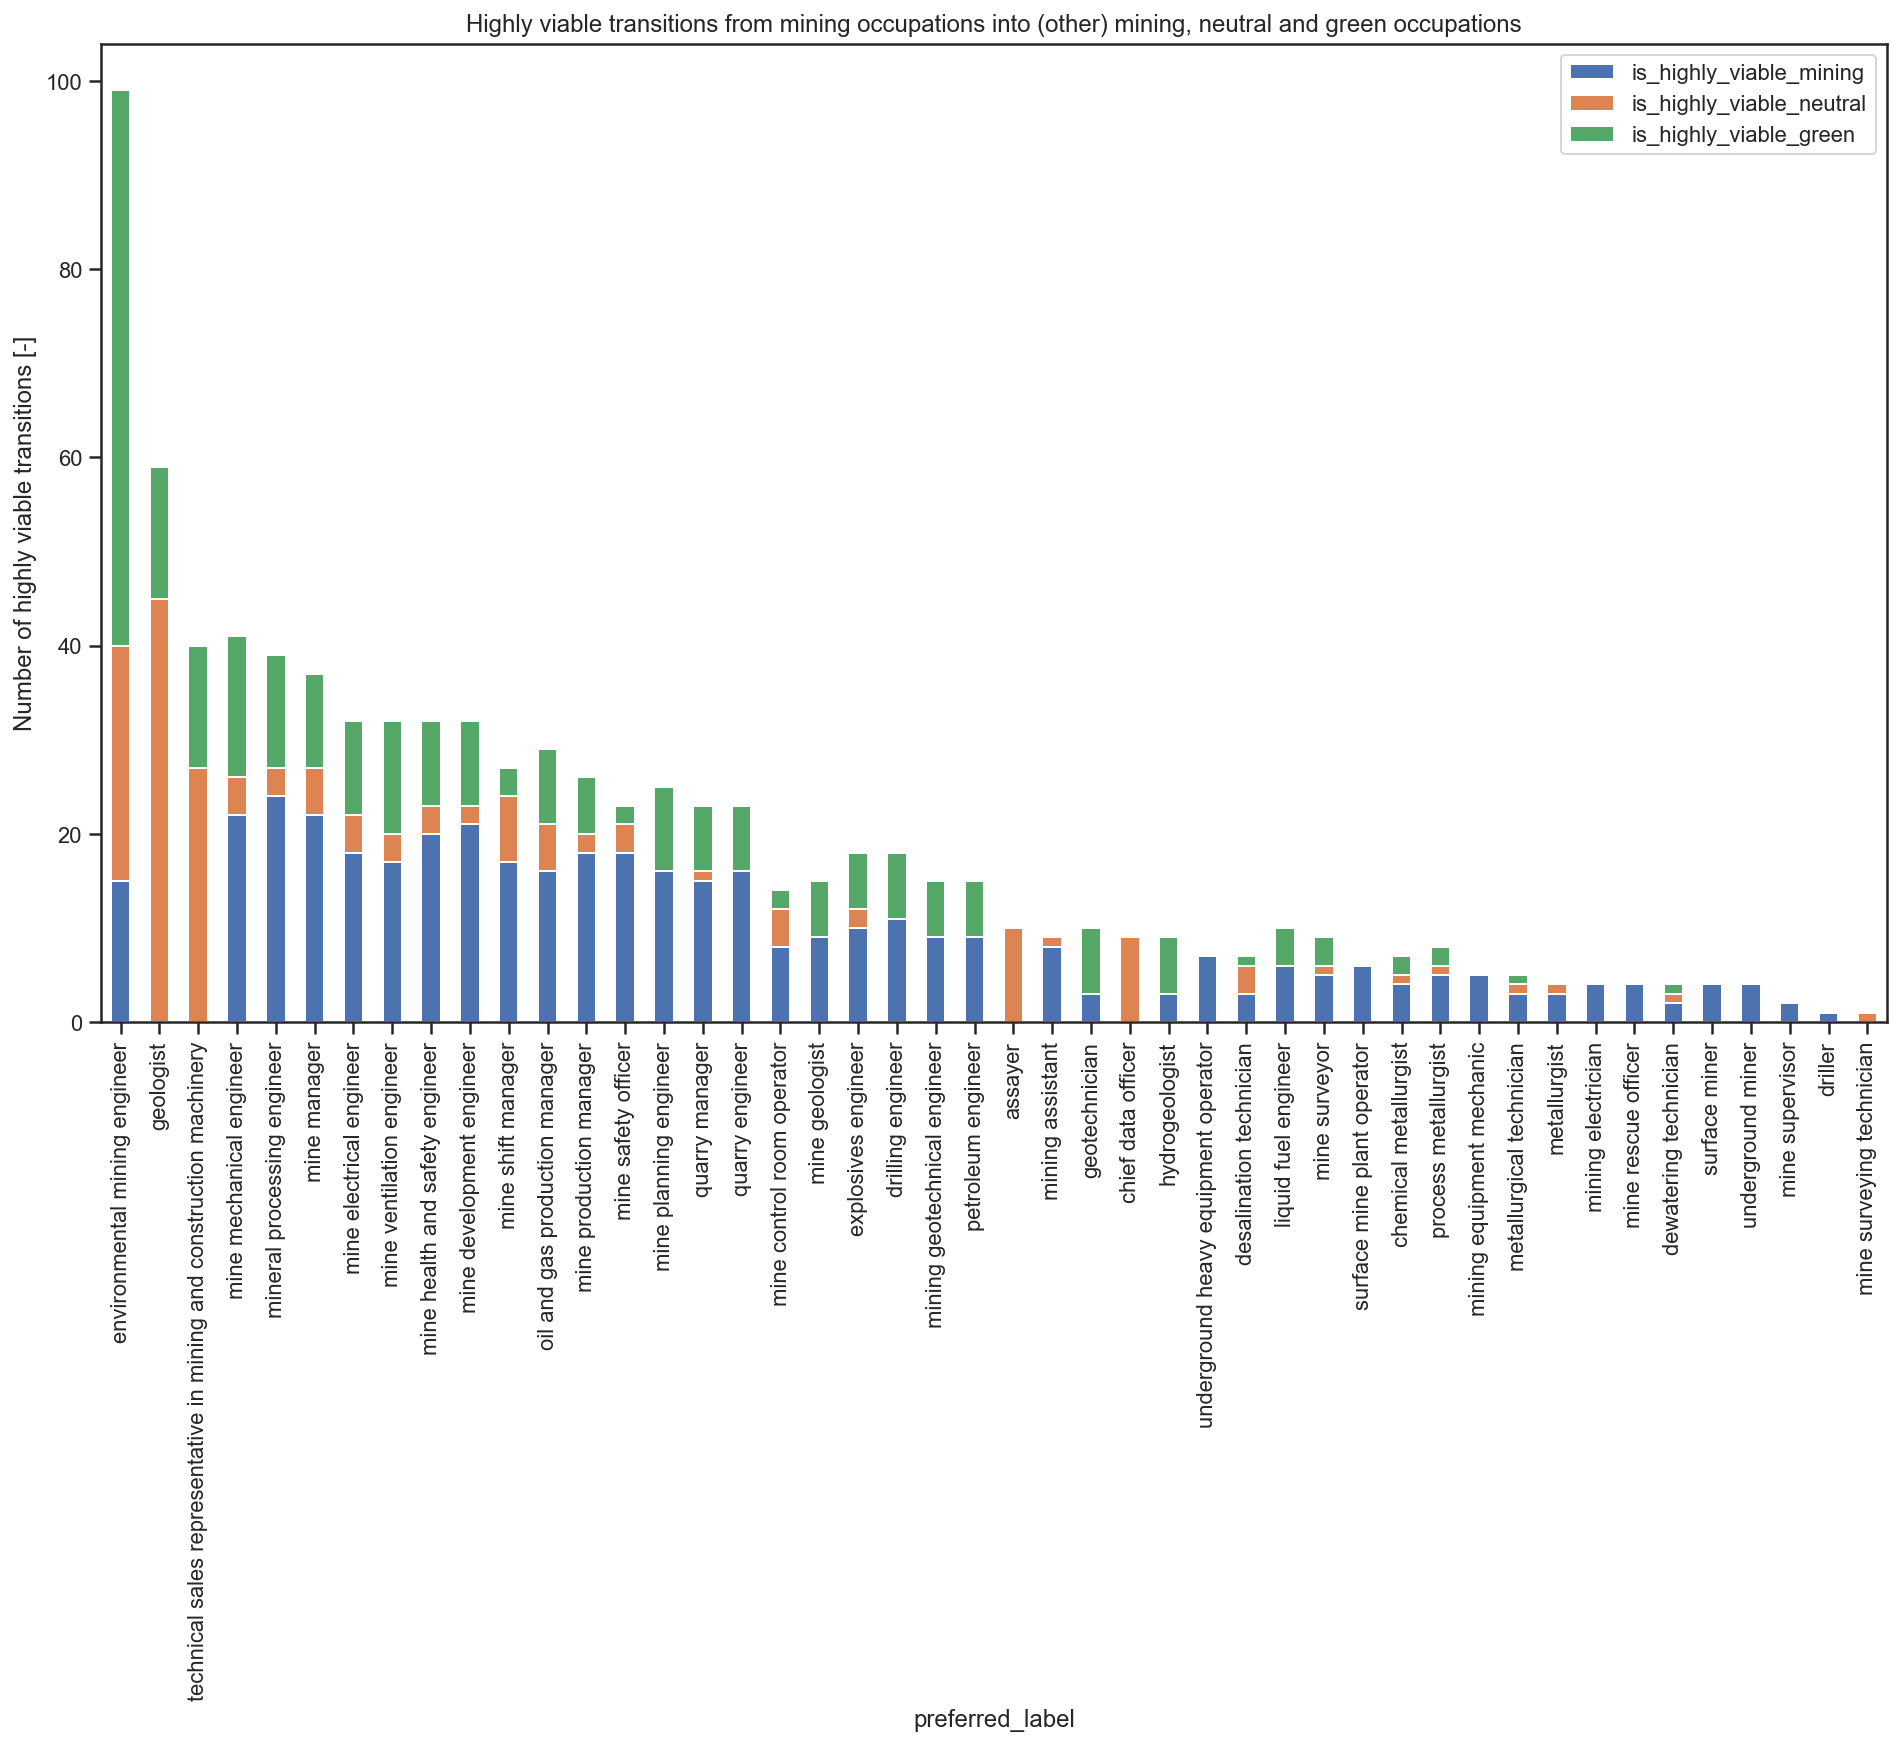

In [262]:
# highly viable transitions
(df_transition_numbers_labelled
 .sort_values("is_highly_viable", ascending=False)[["is_highly_viable_mining", "is_highly_viable_neutral", "is_highly_viable_green", "preferred_label"]]
 .plot.bar(
    x="preferred_label",
    sharey=False,
    stacked=True,
    title="Highly viable transitions from mining occupations into (other) mining, neutral and green occupations",
    ylabel="Number of highly viable transitions [-]"
 )
)

plt.savefig(
    os.path.join(figure_dir, "n_highly_viable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

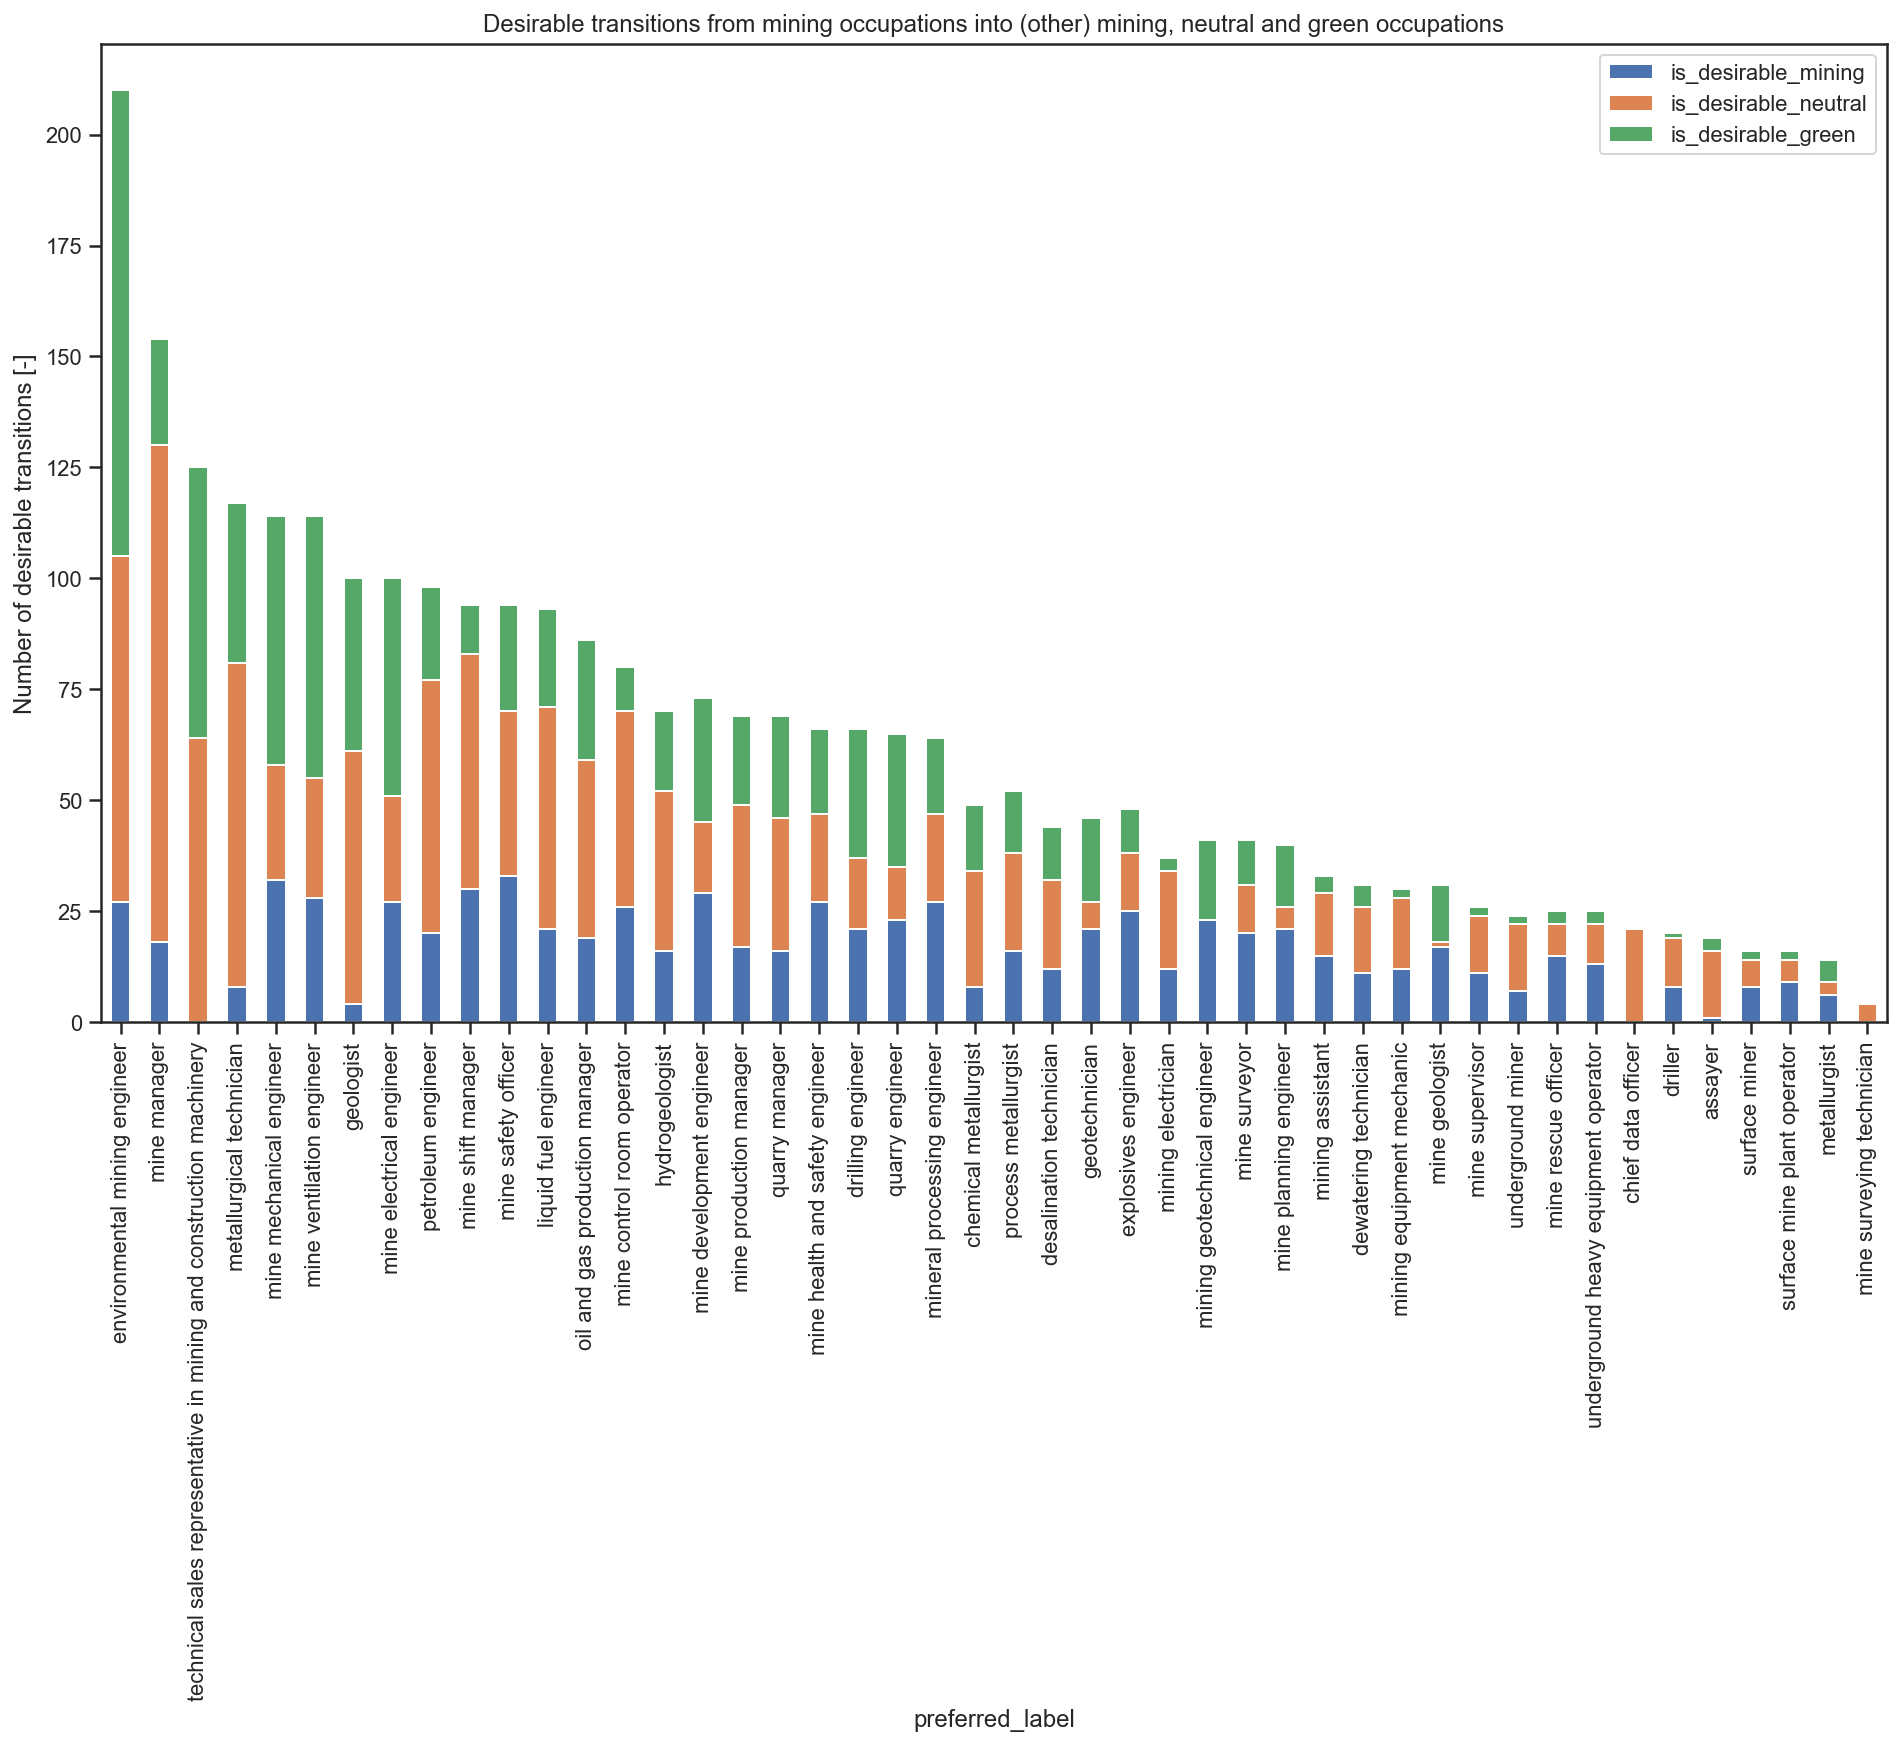

In [263]:
# desirable transitions
(df_transition_numbers_labelled
 .sort_values("is_desirable", ascending=False)[["is_desirable_mining", "is_desirable_neutral", "is_desirable_green", "preferred_label"]]
 .plot.bar(
    x="preferred_label",
    sharey=False,
    stacked=True,
    title="Desirable transitions from mining occupations into (other) mining, neutral and green occupations",
    ylabel="Number of desirable transitions [-]"
 )
)

plt.savefig(
    os.path.join(figure_dir, "n_desirable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

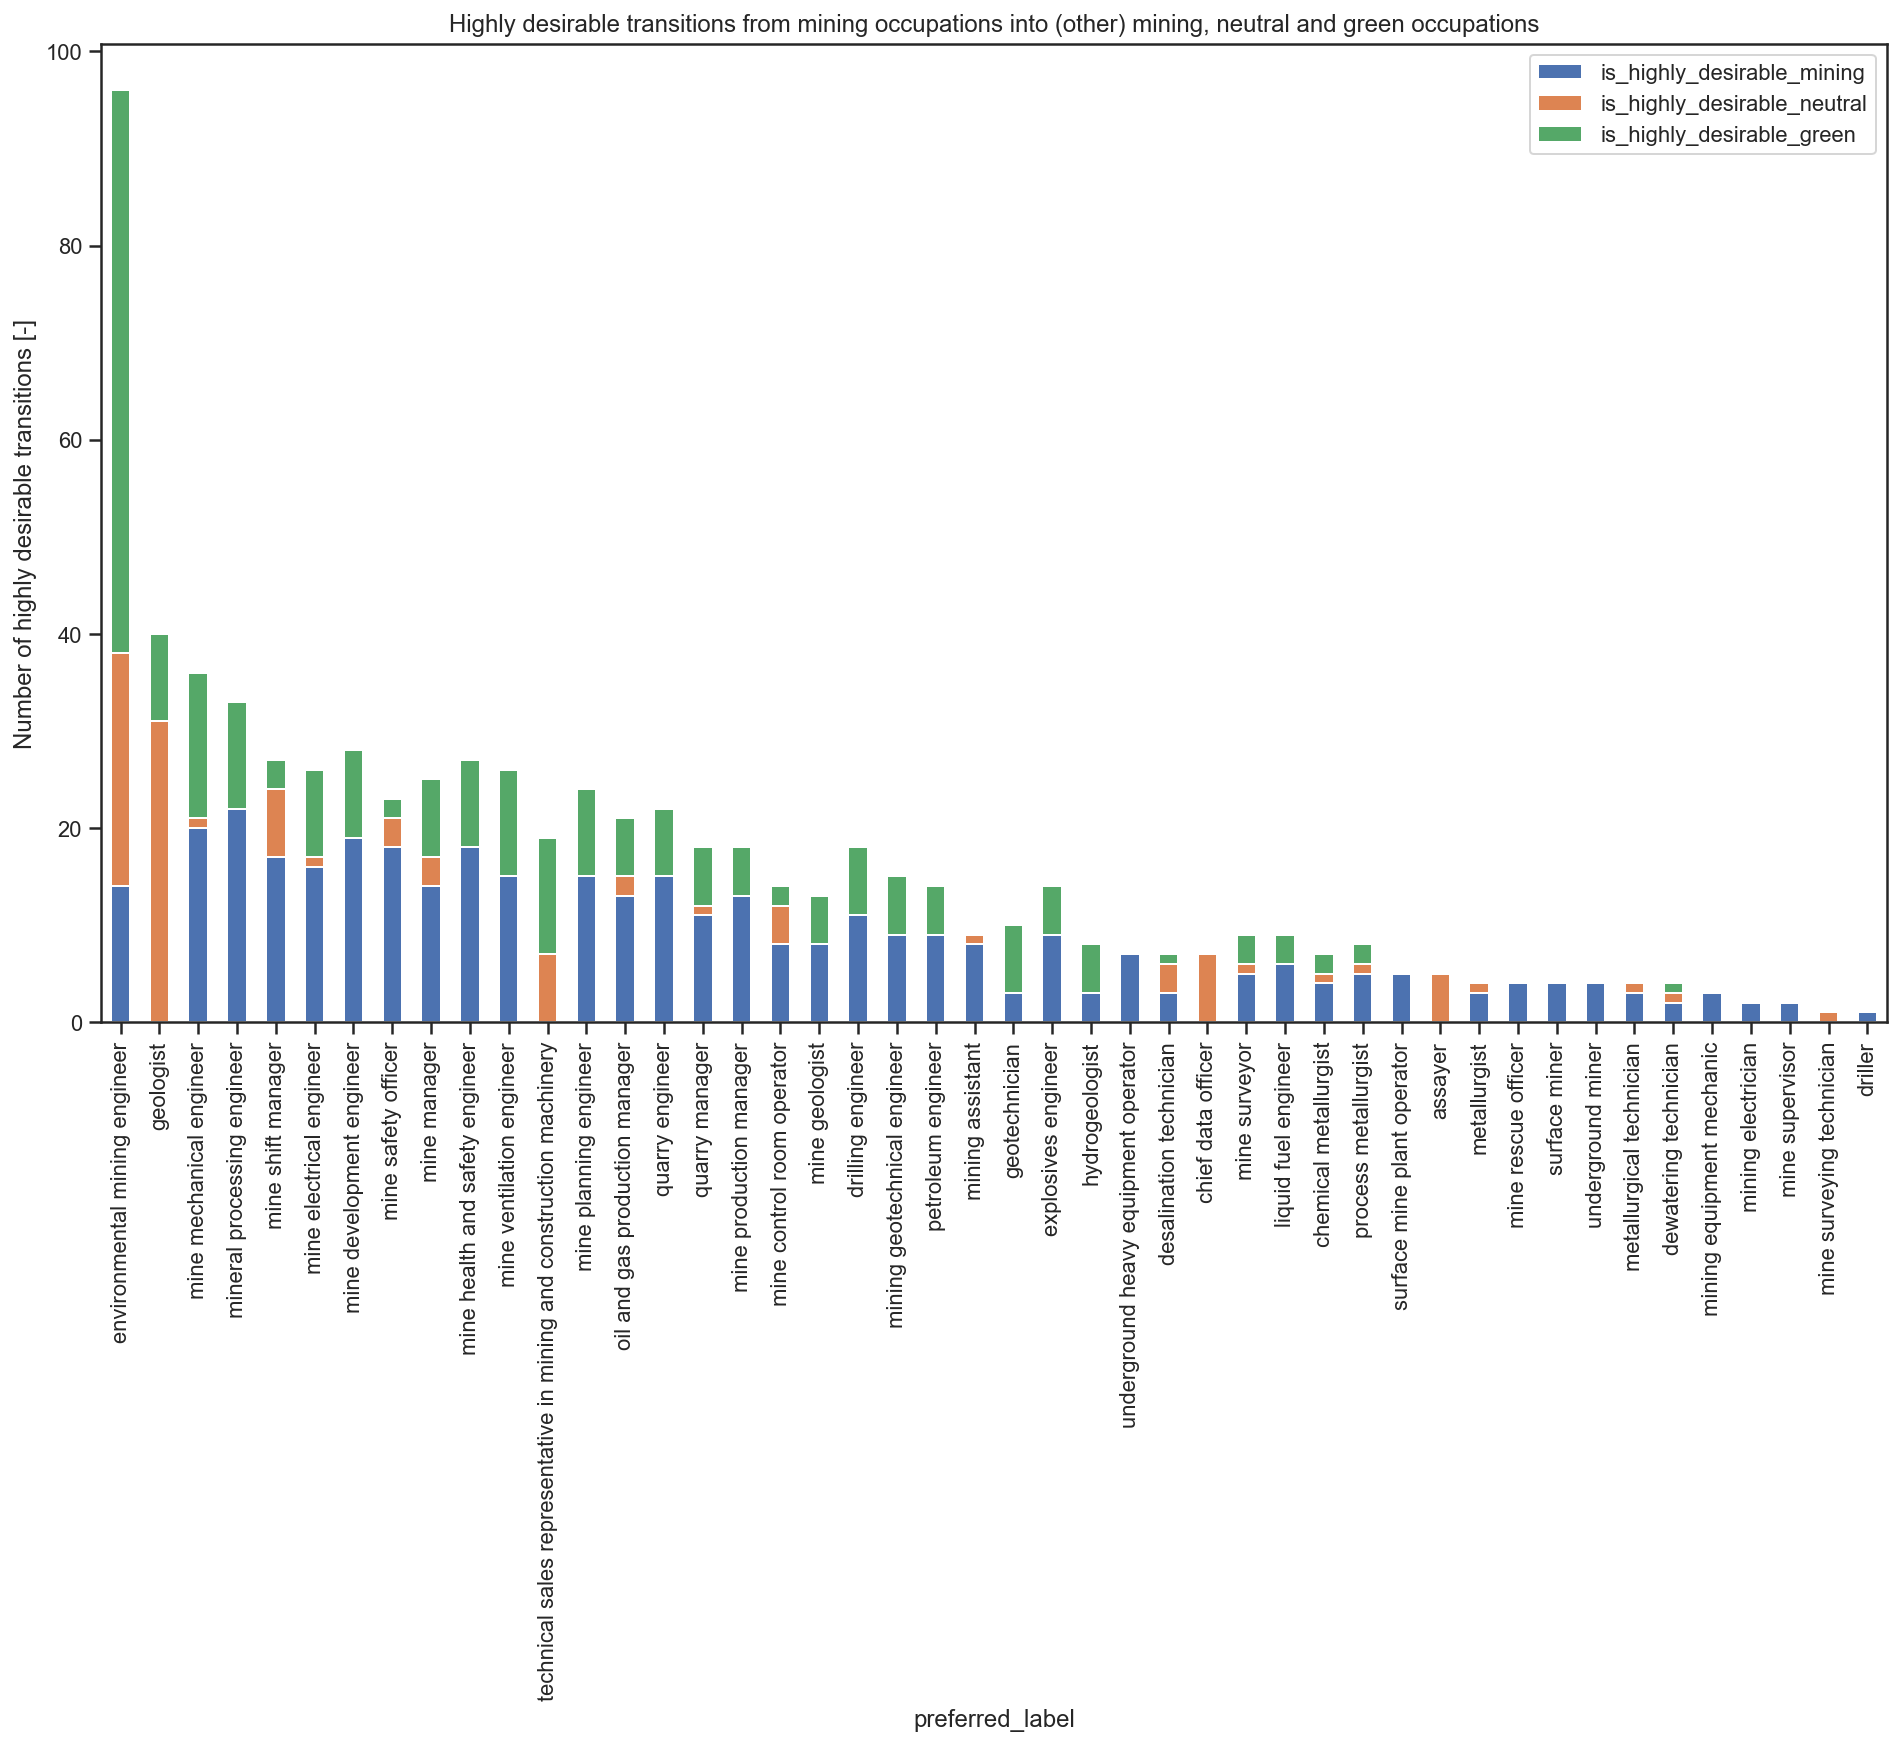

In [264]:
# highly desirable transitions
(df_transition_numbers_labelled
 .sort_values("is_highly_desirable", ascending=False)[["is_highly_desirable_mining", "is_highly_desirable_neutral", "is_highly_desirable_green", "preferred_label"]]
 .plot.bar(
    x="preferred_label",
    sharey=False,
    stacked=True,
    title="Highly desirable transitions from mining occupations into (other) mining, neutral and green occupations",
    ylabel="Number of highly desirable transitions [-]"
 )
)

plt.savefig(
    os.path.join(figure_dir, "n_highly_desirable_transitions.png"),
    dpi=150,
    bbox_inches="tight"
)

## Iterate over all occupations and identify transition options

In [268]:
transition_numbers_all = {}
df_occ = pd.DataFrame(occ.conceptUri.values, columns=["conceptUri"])

# iterate over mining occupations
for i in tqdm(df_metadata.id):

    # find closest occupations
    sim_ranking = find_closest(
        i=i,
        similarity_matrix=sim_kanders,
        df=df_occ
    )

    # print source occupation
    source_occ = df_metadata.loc[i, :]
    # print("Source occupation: {}".format(source_occ.preferred_label))

    # merge metadata
    result = pd.merge(
        sim_ranking,
        df_metadata[[
            "concept_uri",
            "preferred_label",
            "greenness_vona_2018",
            "annual_earnings",
            "is_mining",
        ]],
        left_on="conceptUri",
        right_on="concept_uri",
        how="left"
    ).drop(columns=["concept_uri"], axis=1)

    # add transitions metadata
    result["earnings_ratio"] = result.annual_earnings / source_occ.annual_earnings
    result["is_viable"] = result.similarity >= 0.3
    result["is_highly_viable"] = result.similarity >= 0.4
    result["is_desirable"] = result.is_viable & (result.earnings_ratio >= 0.75)
    result["is_highly_desirable"] = result.is_highly_viable & (result.earnings_ratio >= 0.75)
    result["is_green"] = result.greenness_vona_2018 > 0
    result["is_neutral"] = (result.greenness_vona_2018 == 0) & (result.is_mining == False)

    # highly viable transitions
    result["is_highly_viable_mining"] = (result.similarity >= 0.4) & (result.is_mining == True)
    result["is_highly_viable_neutral"] = (result.similarity >= 0.4) & (result.is_neutral == True)
    result["is_highly_viable_green"] = (result.similarity >= 0.4) & (result.is_green == True)

    # desirable transitions
    result["is_desirable_mining"] = result.is_desirable & (result.is_mining == True)
    result["is_desirable_neutral"] = result.is_desirable & (result.is_neutral == True)
    result["is_desirable_green"] = result.is_desirable & (result.is_green == True)

    # highly desirable transitions
    result["is_highly_desirable_mining"] = result.is_highly_desirable & (result.is_mining == True)
    result["is_highly_desirable_neutral"] = result.is_highly_desirable & (result.is_neutral == True)
    result["is_highly_desirable_green"] = result.is_highly_desirable & (result.is_green == True)

    # subset to viable transitions
    result_subset = result[result.is_viable == True]

    # subset to boolean cols
    boolean_cols = [
        'is_viable', 'is_highly_viable', 'is_desirable', 'is_highly_desirable',
        'is_green', 'is_neutral', 'is_mining',
        'is_highly_viable_mining', 'is_highly_viable_neutral', 'is_highly_viable_green',
        'is_desirable_mining', 'is_desirable_neutral', 'is_desirable_green',
        'is_highly_desirable_mining', 'is_highly_desirable_neutral', 'is_highly_desirable_green'
    ]

    # subset to viable transitions only
    result_subset_bools = result_subset[boolean_cols]

    # count True's per boolean column
    s_sum = result_subset_bools.sum()

    transition_numbers_all[i] = s_sum

100%|██████████| 2942/2942 [00:54<00:00, 54.04it/s]


In [317]:
# to df
cols_merge = ["preferred_label", "isco_level_1"] #, "annual_earnings", "education_level", "related_work_experience", "on_the_job_training"]
df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled = pd.concat(
    [df_transition_numbers_all, df_metadata[cols_merge]], axis=1
)

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_mining,is_highly_viable_mining,is_highly_viable_neutral,is_highly_viable_green,is_desirable_mining,is_desirable_neutral,is_desirable_green,is_highly_desirable_mining,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1
0,20,0,18,0,2,18,0,0,0,0,0,16,2,0,0,0,technical director,2
1,175,123,175,123,11,164,0,0,119,4,0,164,11,0,119,4,metal drawing machine operator,8
2,274,62,273,62,59,212,3,0,34,28,3,212,58,0,34,28,precision device inspector,7
3,62,2,57,2,10,52,1,0,2,0,1,50,7,0,2,0,air traffic safety technician,3
4,238,14,203,13,72,164,2,0,12,2,2,133,68,0,11,2,hospitality revenue manager,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,83,36,76,33,24,59,1,1,27,9,1,55,21,1,26,7,demographer,2
2938,12,4,11,4,6,6,0,0,0,4,0,5,6,0,0,4,sorter labourer,9
2939,44,16,39,16,2,42,0,0,16,0,0,37,2,0,16,0,armoured car guard,5
2940,59,5,37,4,5,54,0,0,5,0,0,32,5,0,4,0,civil service administrative officer,2


## Visualise transition numbers for all occupations

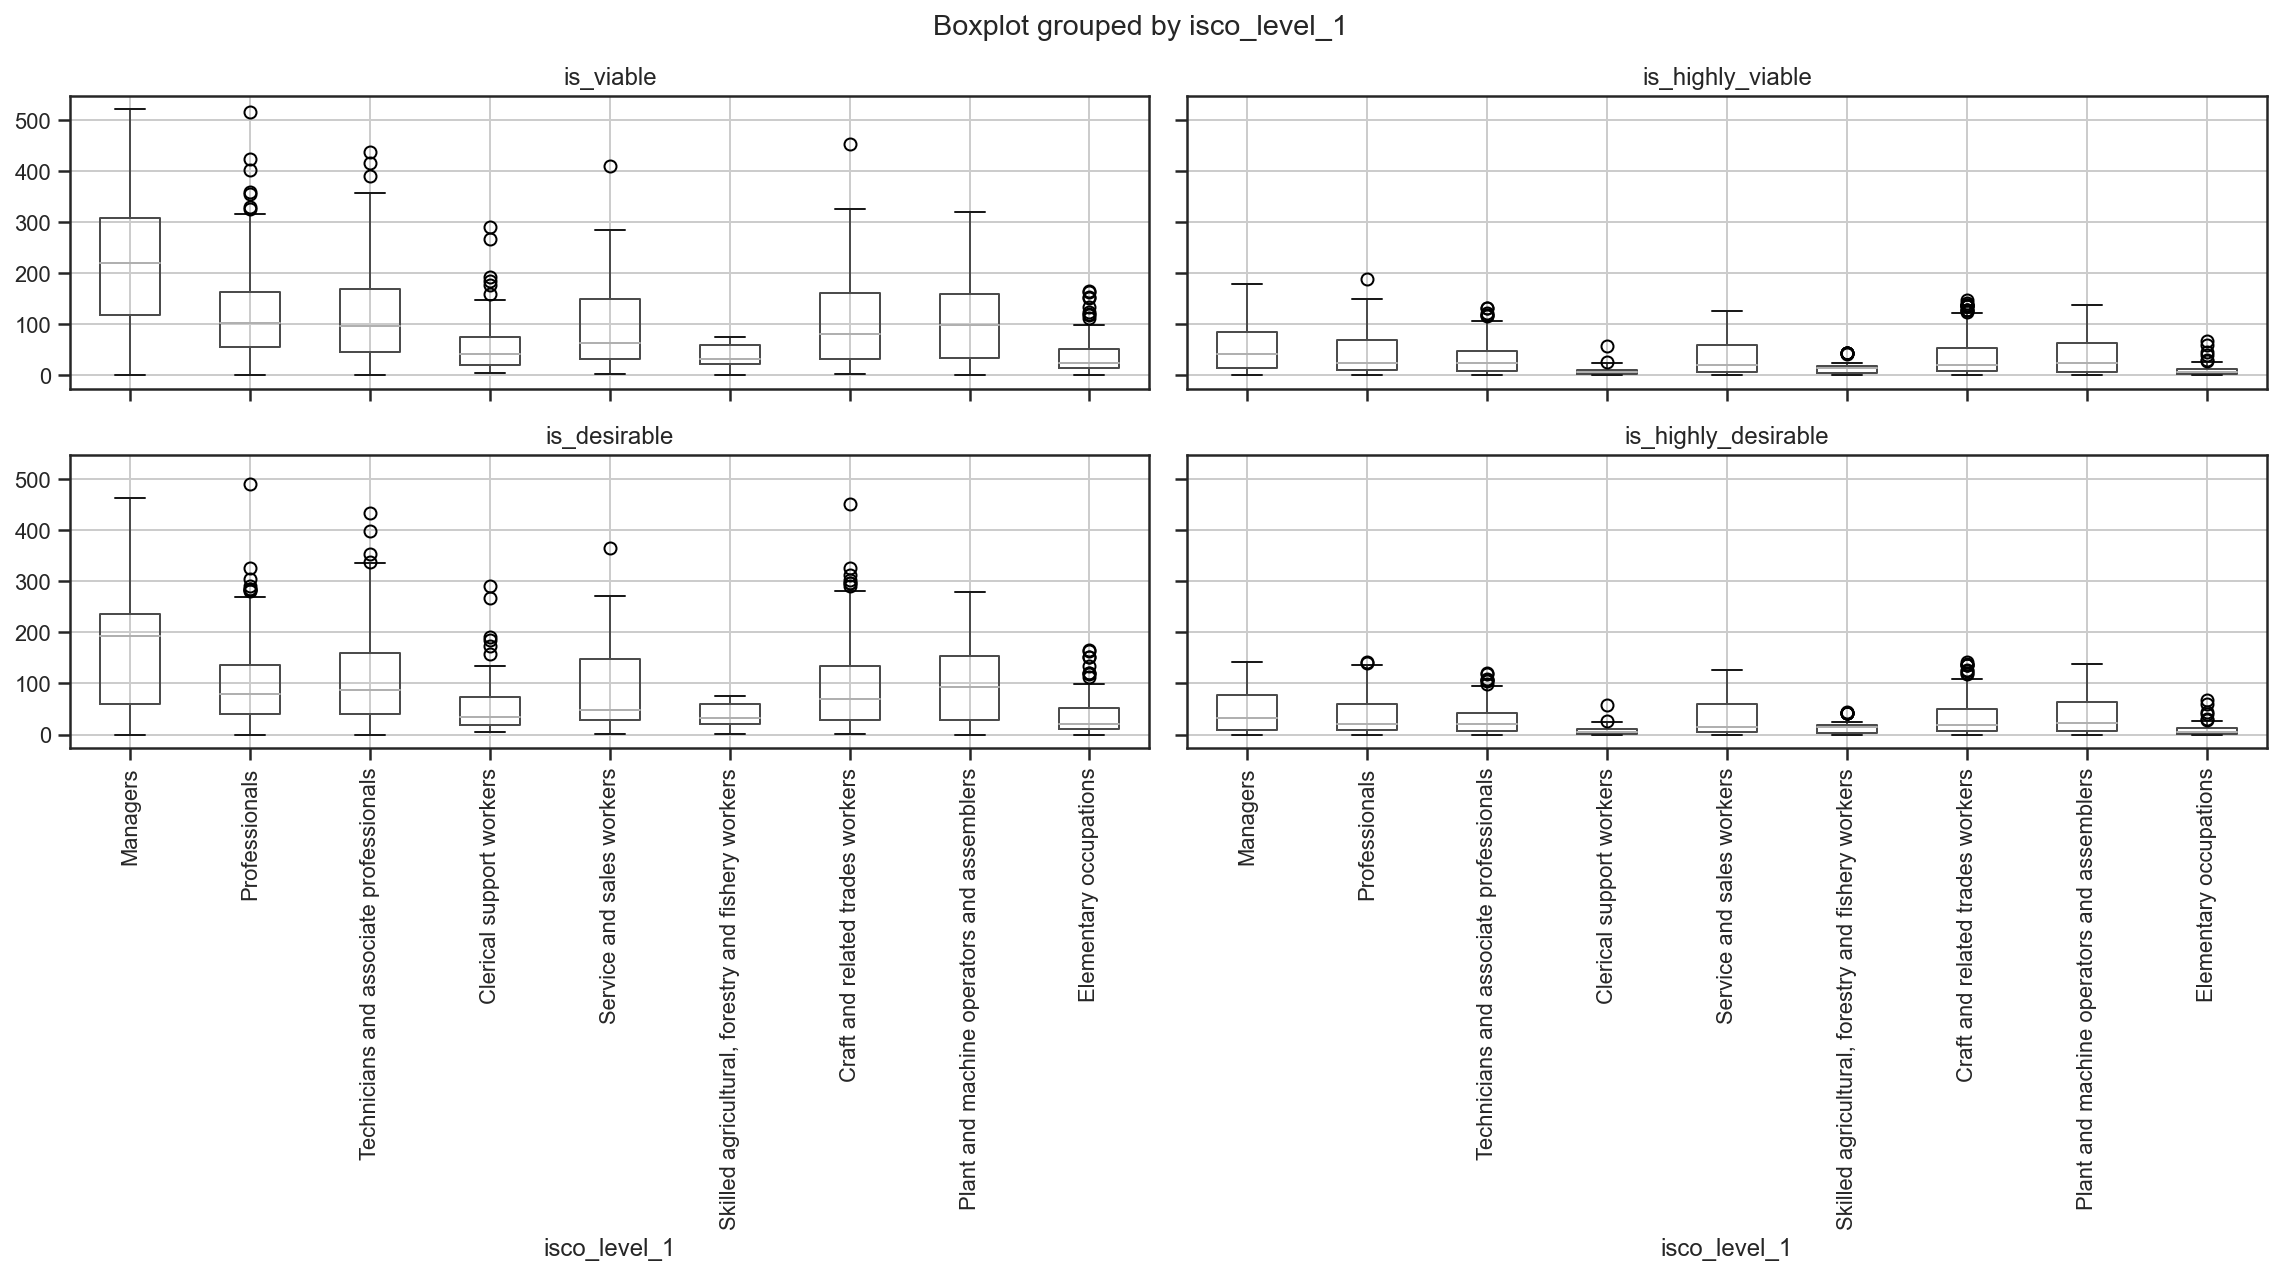

In [301]:
# boxplots of transition numbers by isco lvl 1 groups
isco_lvl1_mapping = {
    1: "Managers",
    2: "Professionals",
    3: "Technicians and associate professionals",
    4: "Clerical support workers",
    5: "Service and sales workers",
    6: "Skilled agricultural, forestry and fishery workers",
    7: "Craft and related trades workers",
    8: "Plant and machine operators and assemblers",
    9: "Elementary occupations"
}

df_transition_numbers_all_labelled.boxplot(
    column=["is_viable", "is_highly_viable", "is_desirable", "is_highly_desirable"],
    by="isco_level_1",
    layout=(2,2),
    rot=90
)

plt.xticks(np.arange(1,10), list(isco_lvl1_mapping.values()))

plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

In [323]:
df_transition_numbers_all_labelled

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_mining,is_highly_viable_mining,is_highly_viable_neutral,is_highly_viable_green,is_desirable_mining,is_desirable_neutral,is_desirable_green,is_highly_desirable_mining,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1
0,20,0,18,0,2,18,0,0,0,0,0,16,2,0,0,0,technical director,2
1,175,123,175,123,11,164,0,0,119,4,0,164,11,0,119,4,metal drawing machine operator,8
2,274,62,273,62,59,212,3,0,34,28,3,212,58,0,34,28,precision device inspector,7
3,62,2,57,2,10,52,1,0,2,0,1,50,7,0,2,0,air traffic safety technician,3
4,238,14,203,13,72,164,2,0,12,2,2,133,68,0,11,2,hospitality revenue manager,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,83,36,76,33,24,59,1,1,27,9,1,55,21,1,26,7,demographer,2
2938,12,4,11,4,6,6,0,0,0,4,0,5,6,0,0,4,sorter labourer,9
2939,44,16,39,16,2,42,0,0,16,0,0,37,2,0,16,0,armoured car guard,5
2940,59,5,37,4,5,54,0,0,5,0,0,32,5,0,4,0,civil service administrative officer,2


In [329]:
# Visualise differences in transition options to neutral, green and mining
# occupations

value_vars = list(filter(None, [col_label if "is_" in col_label else None for col_label in df_transition_numbers_all_labelled.columns]))
df_ntrans_long = df_transition_numbers_all_labelled.melt(value_vars=value_vars, id_vars=['preferred_label', 'isco_level_1'])

,preferred_label,isco_level_1,variable,value
0,technical director,2,is_viable,20
1,metal drawing machine operator,8,is_viable,175
2,precision device inspector,7,is_viable,274
3,air traffic safety technician,3,is_viable,62
4,hospitality revenue manager,2,is_viable,238
...,...,...,...,...
47067,demographer,2,is_highly_desirable_green,7
47068,sorter labourer,9,is_highly_desirable_green,4
47069,armoured car guard,5,is_highly_desirable_green,0
47070,civil service administrative officer,2,is_highly_desirable_green,0


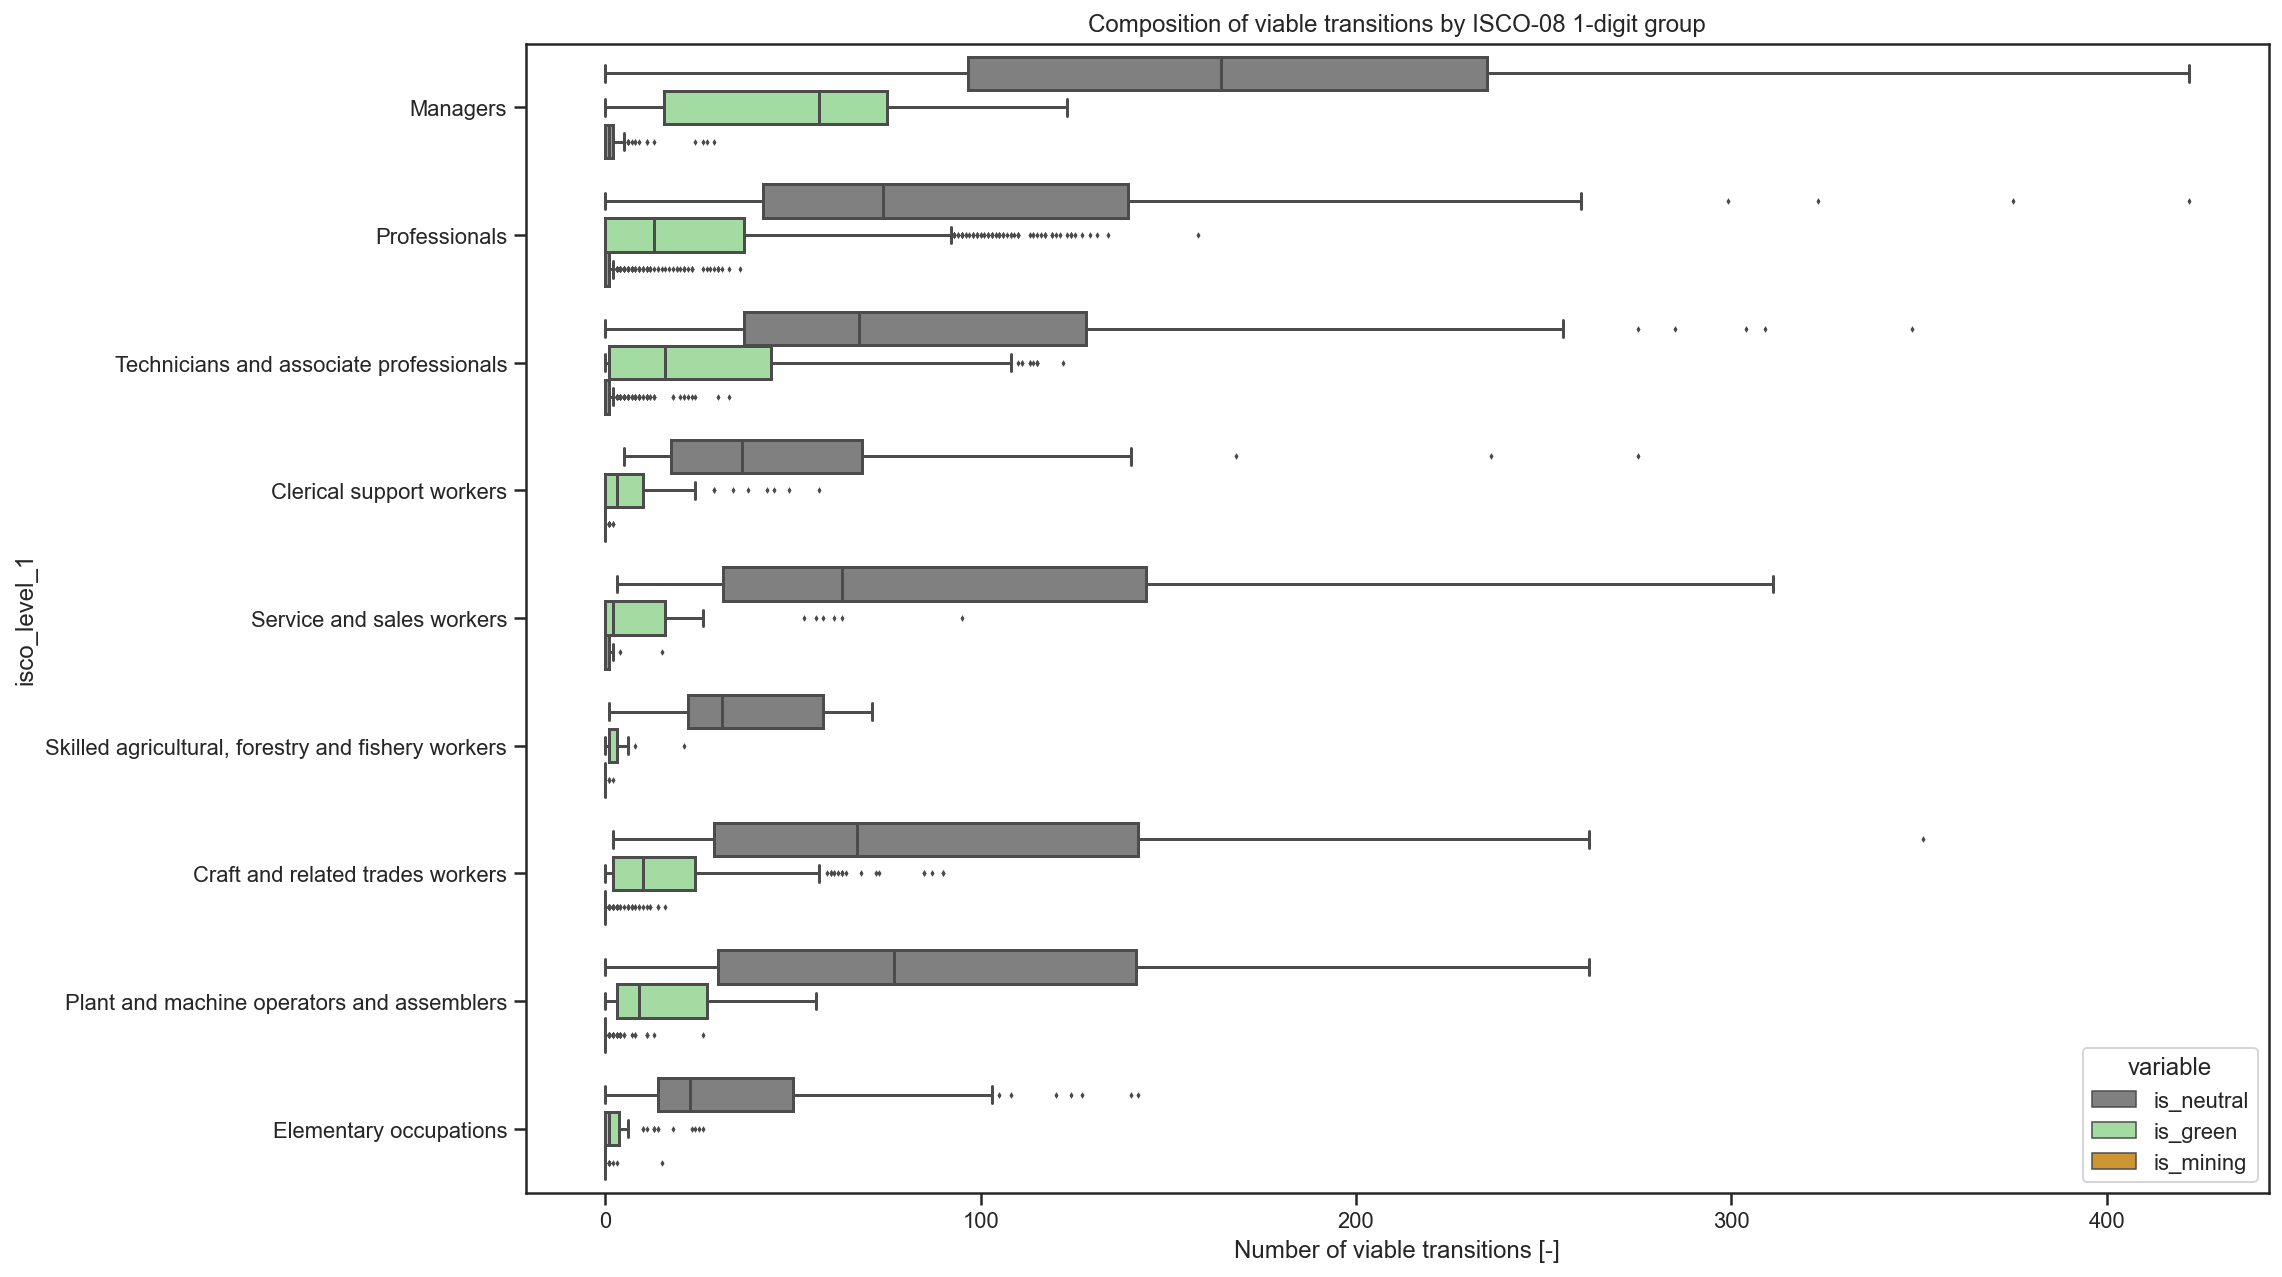

In [368]:
# viable
df_ntrans_long_is_viable = df_ntrans_long.query("variable == 'is_mining' or variable == 'is_neutral' or variable == 'is_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_neutral", "is_green", "is_mining"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_viable
)

ax.set_title("Composition of viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of viable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_viable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

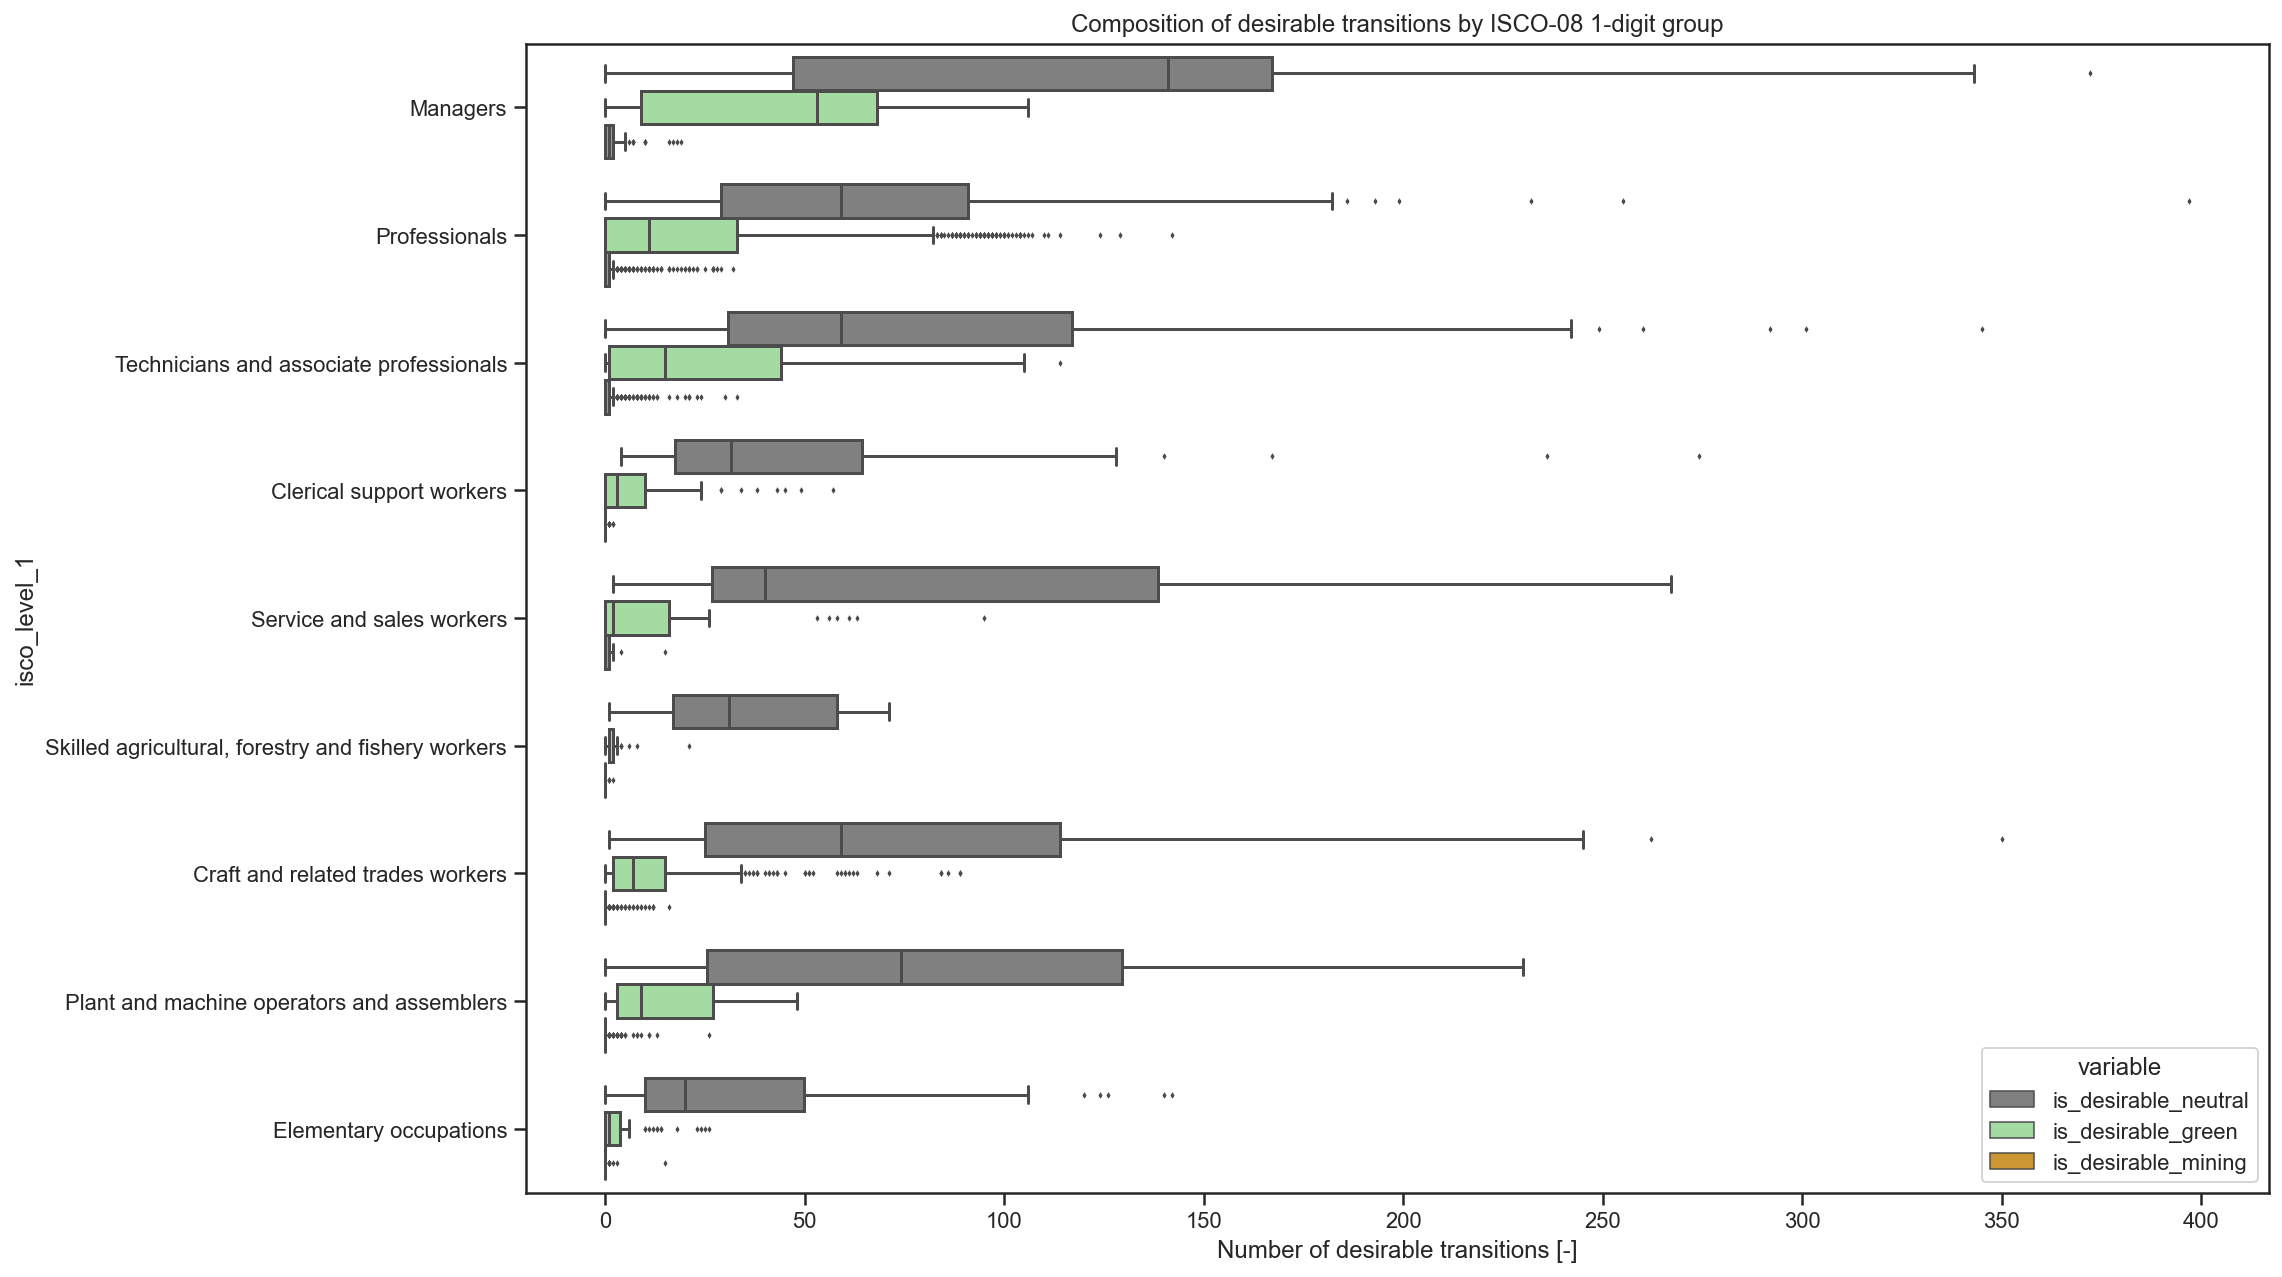

In [369]:
# desirable
df_ntrans_long_is_desirable = df_ntrans_long.query("variable == 'is_desirable_mining' or variable == 'is_desirable_neutral' or variable == 'is_desirable_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_desirable_neutral", "is_desirable_green", "is_desirable_mining"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_desirable
)

ax.set_title("Composition of desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of desirable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_desirable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

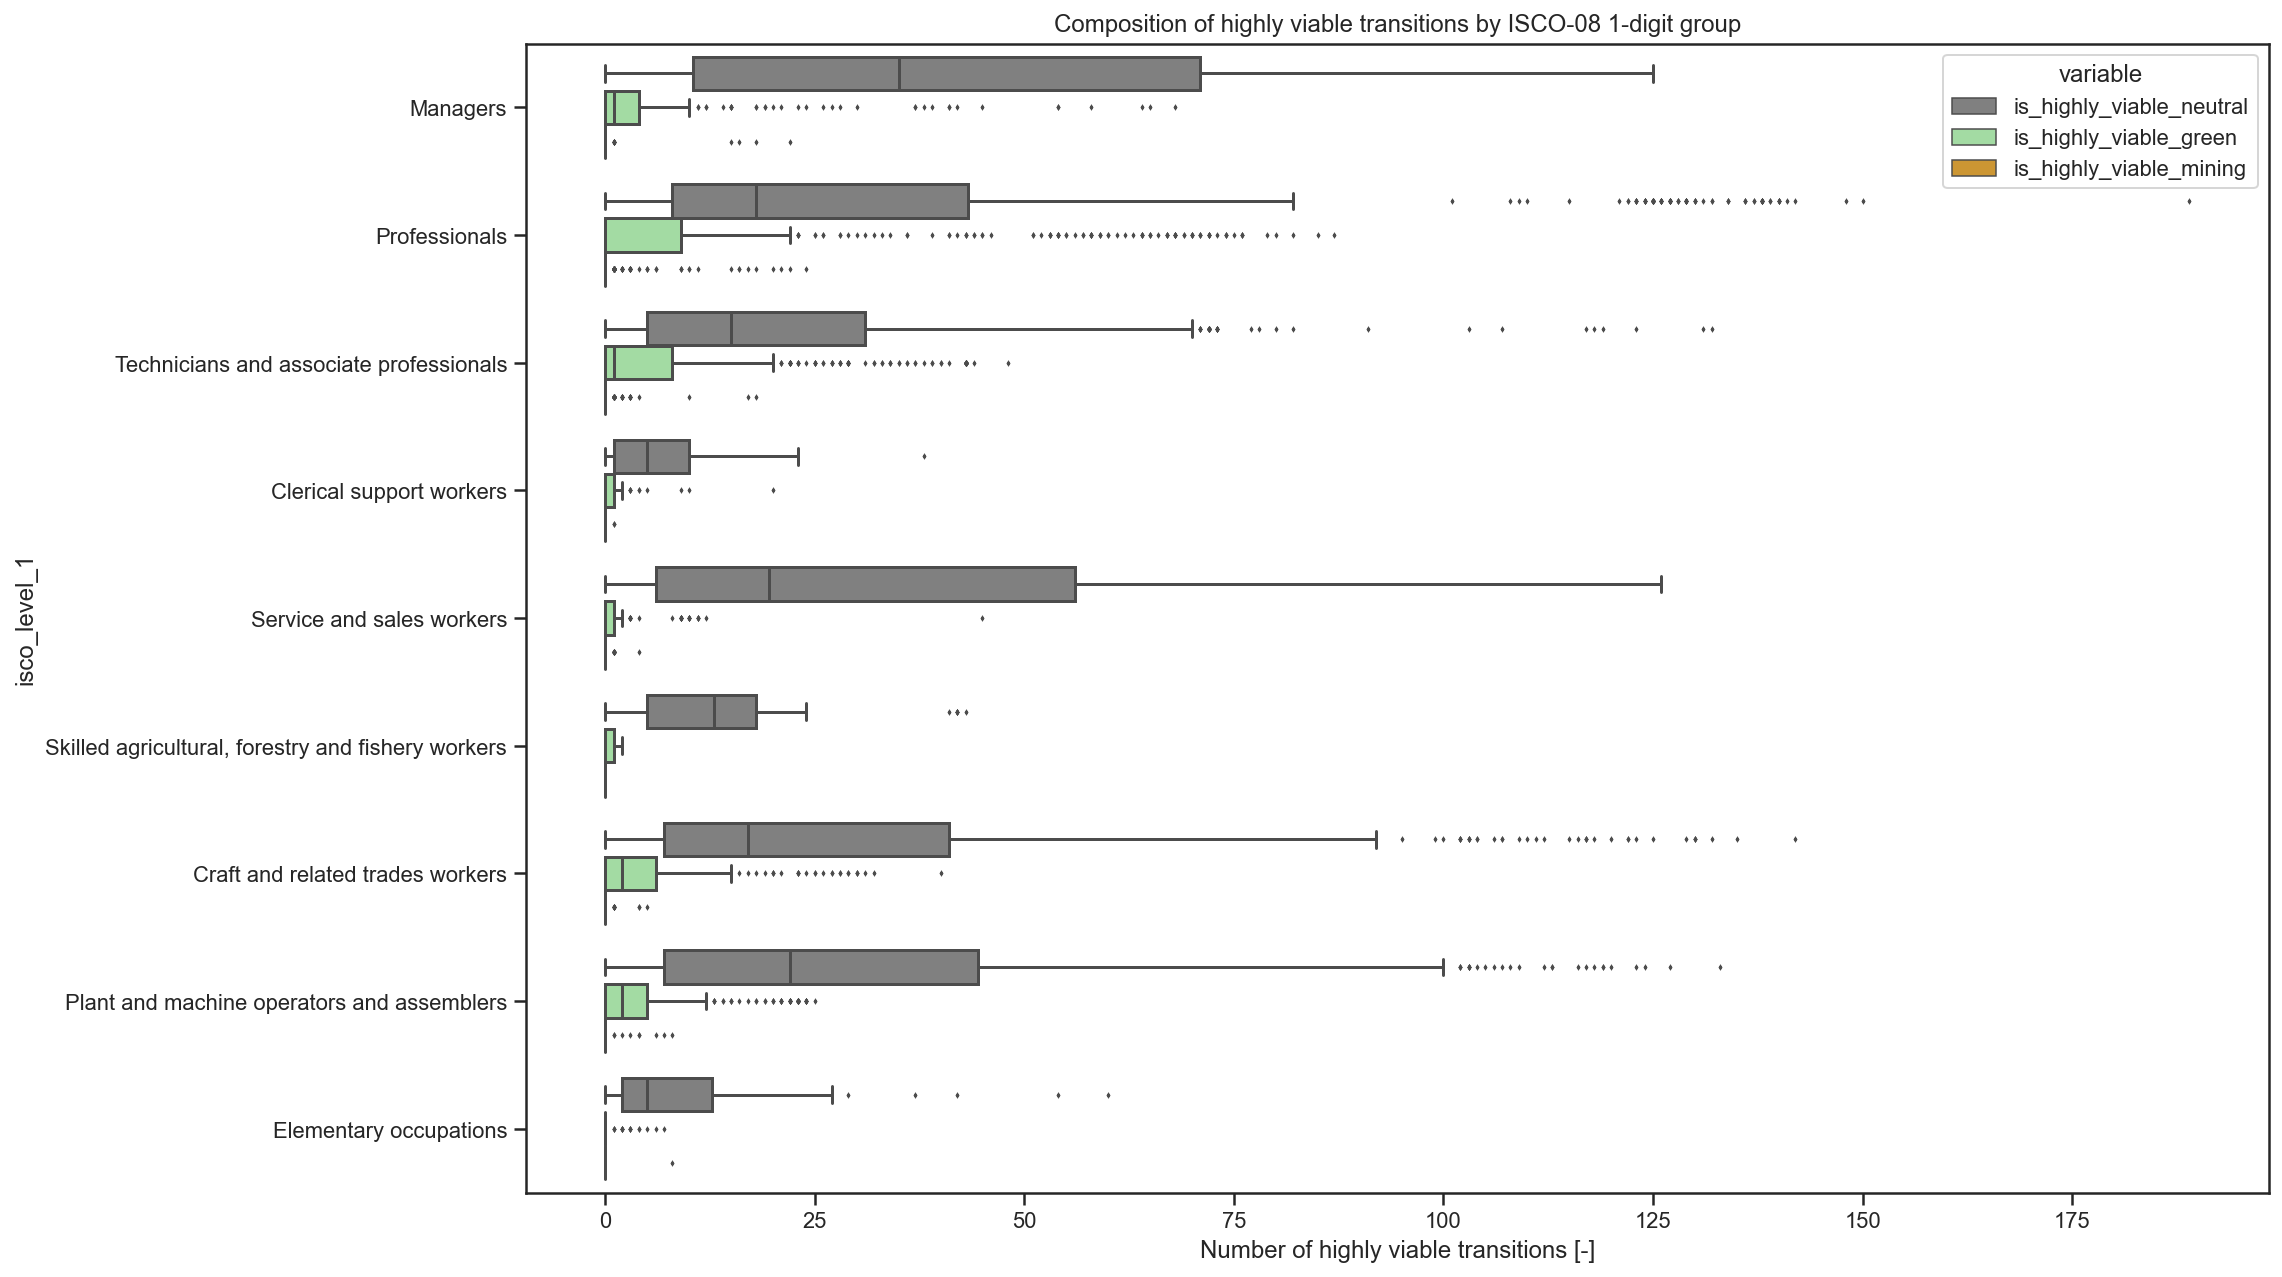

In [370]:
# highly viable
df_ntrans_long_is_highly_viable = df_ntrans_long.query("variable == 'is_highly_viable_mining' or variable == 'is_highly_viable_neutral' or variable == 'is_highly_viable_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_highly_viable_neutral", "is_highly_viable_green", "is_highly_viable_mining"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_viable
)

ax.set_title("Composition of highly viable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly viable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_highly_viable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

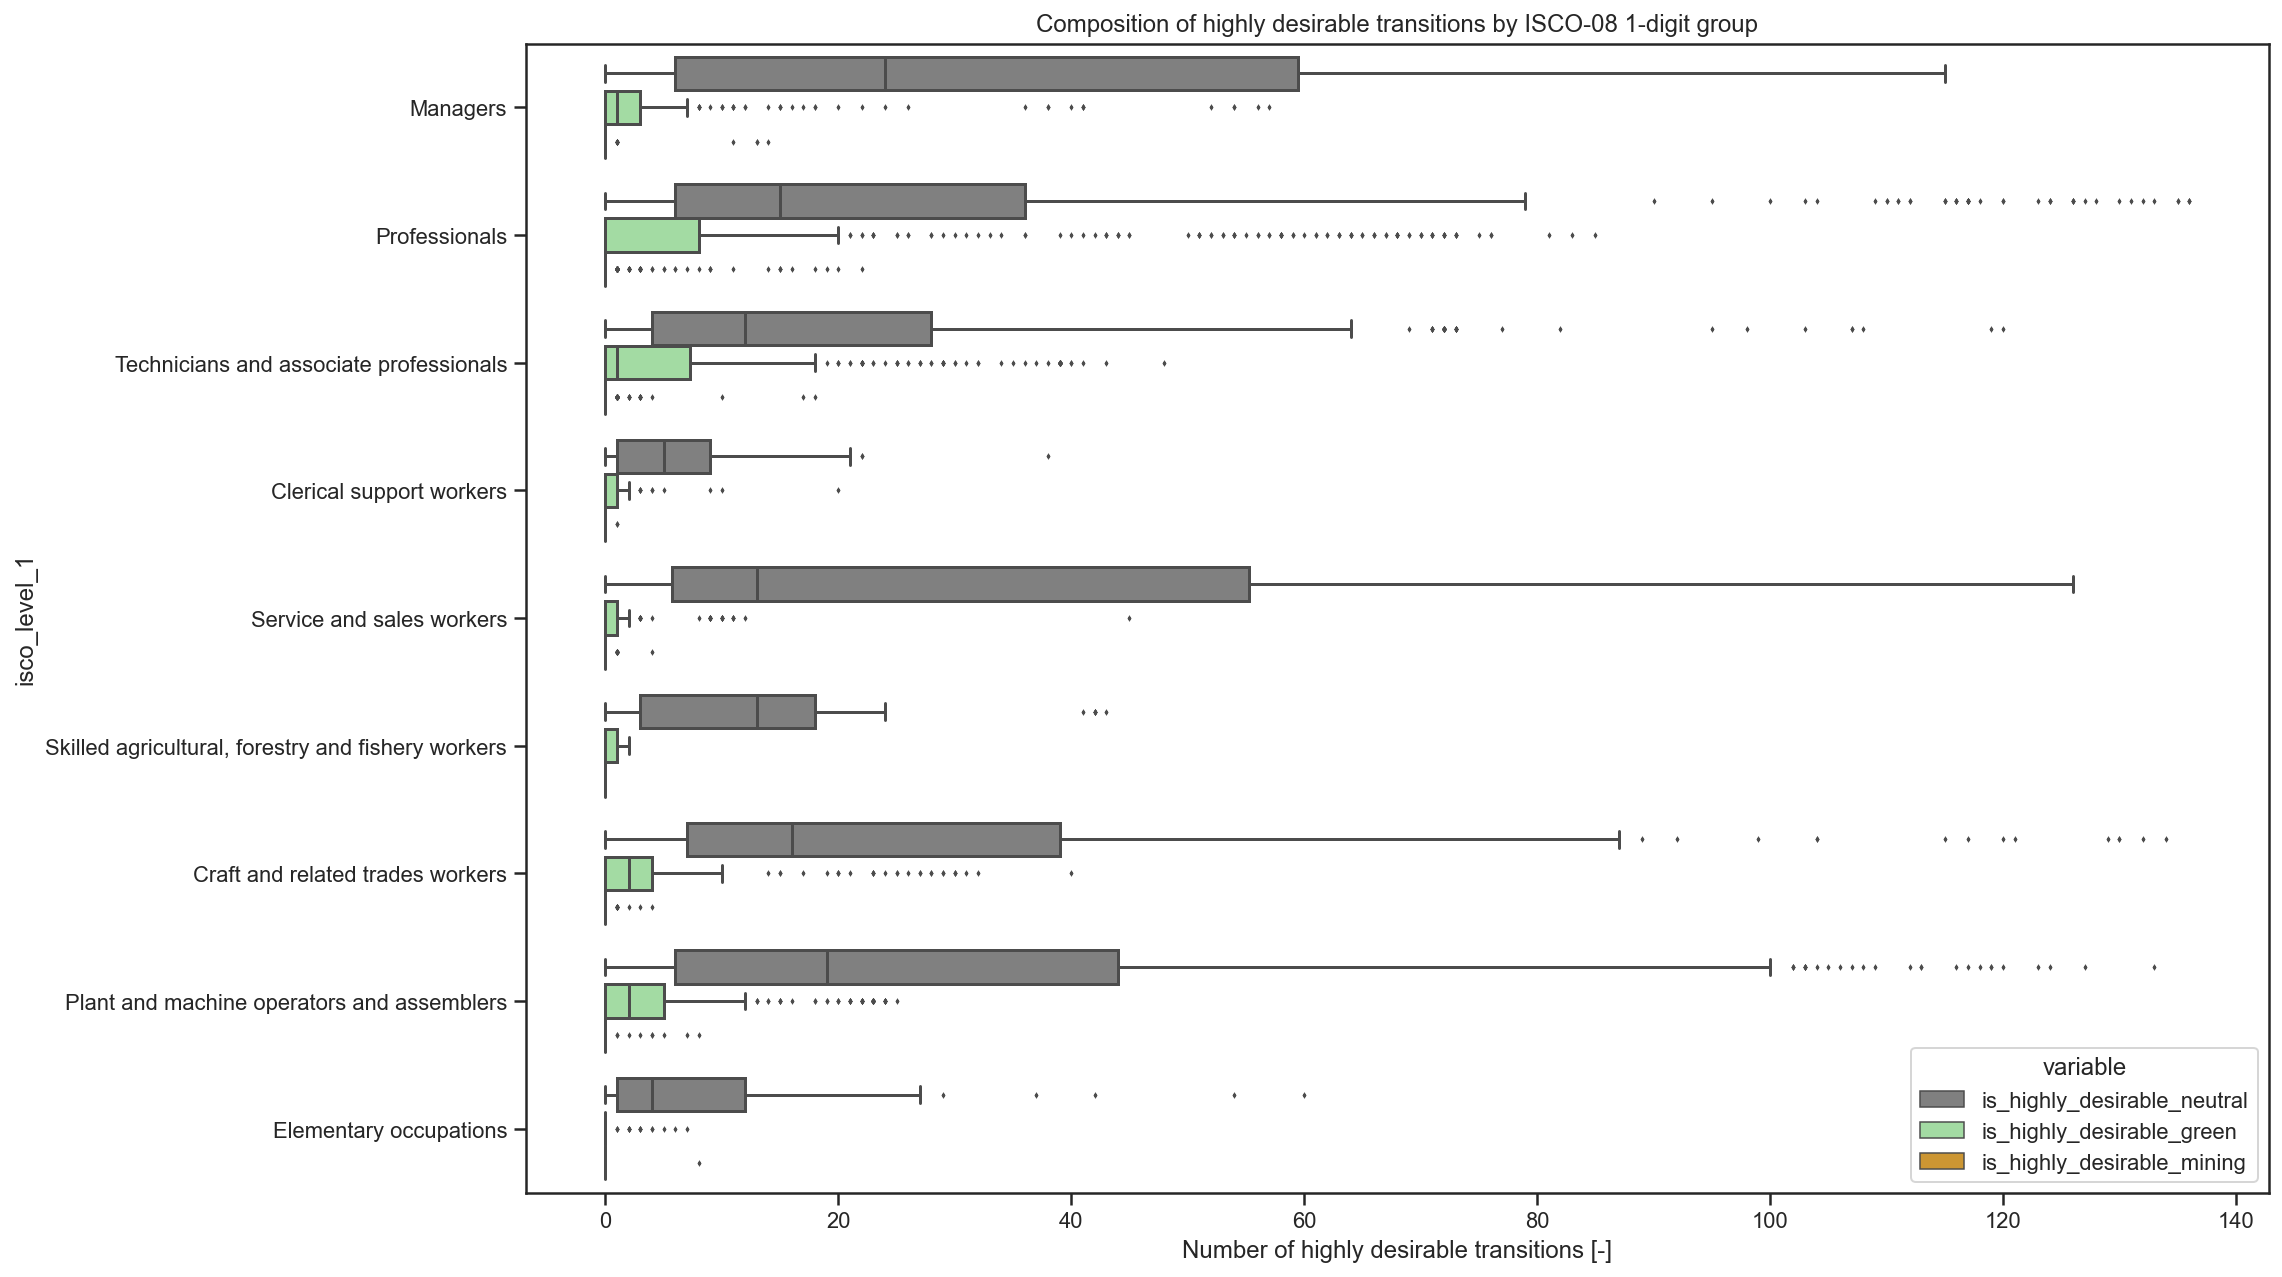

In [371]:
df_ntrans_long_is_highly_desirable = df_ntrans_long.query("variable == 'is_highly_desirable_mining' or variable == 'is_highly_desirable_neutral' or variable == 'is_highly_desirable_green'")

ax = sns.boxplot(
    y="isco_level_1",
    x="value",
    hue="variable",
    hue_order=["is_highly_desirable_neutral", "is_highly_desirable_green", "is_highly_desirable_mining"],
    palette=["grey", "lightgreen", "orange"],
    saturation=0.6,
    fliersize=1,
    orient="h",
    data=df_ntrans_long_is_highly_desirable
)

ax.set_title("Composition of highly desirable transitions by ISCO-08 1-digit group")
ax.set_xlabel("Number of highly desirable transitions [-]")
plt.yticks(np.arange(0,9), list(isco_lvl1_mapping.values()), rotation='horizontal')
plt.tight_layout()

plt.savefig(
    os.path.join(figure_dir, "n_transitions_all_occ_highly_desirable_composition_isco_lvl1.png"),
    dpi=150,
    bbox_inches="tight"
)

## Regression analysis of transition numbers

In [385]:
# to df
cols_merge = ["preferred_label", "isco_level_1", "annual_earnings", "education_level", "related_work_experience", "on_the_job_training", "job_zone"]
# df_transition_numbers_all = pd.DataFrame.from_dict(transition_numbers_all).transpose()
df_transition_numbers_all_labelled_wide = pd.concat(
    [df_transition_numbers_all, df_metadata[cols_merge]], axis=1
)

df_transition_numbers_all_labelled_wide

,is_viable,is_highly_viable,is_desirable,is_highly_desirable,is_green,is_neutral,is_mining,is_highly_viable_mining,is_highly_viable_neutral,is_highly_viable_green,is_desirable_mining,is_desirable_neutral,is_desirable_green,is_highly_desirable_mining,is_highly_desirable_neutral,is_highly_desirable_green,preferred_label,isco_level_1,annual_earnings,education_level,related_work_experience,on_the_job_training,job_zone
0,20,0,18,0,2,18,0,0,0,0,0,16,2,0,0,0,technical director,2,37555.308176,6.2477,8.0309,4.3843,4.0
1,175,123,175,123,11,164,0,0,119,4,0,164,11,0,119,4,metal drawing machine operator,8,22031.963636,2.1163,2.4383,3.6486,2.0
2,274,62,273,62,59,212,3,0,34,28,3,212,58,0,34,28,precision device inspector,7,22430.367647,2.5397,4.8863,4.0288,2.0
3,62,2,57,2,10,52,1,0,2,0,1,50,7,0,2,0,air traffic safety technician,3,32754.000000,4.3848,5.4808,4.0782,3.0
4,238,14,203,13,72,164,2,0,12,2,2,133,68,0,11,2,hospitality revenue manager,2,38839.816377,6.8261,6.3481,3.8265,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2937,83,36,76,33,24,59,1,1,27,9,1,55,21,1,26,7,demographer,2,36135.290249,8.3000,5.5000,4.6000,5.0
2938,12,4,11,4,6,6,0,0,0,4,0,5,6,0,0,4,sorter labourer,9,21357.054545,3.1532,3.3559,2.8314,2.0
2939,44,16,39,16,2,42,0,0,16,0,0,37,2,0,16,0,armoured car guard,5,24315.540984,2.2215,3.2642,2.0230,2.0
2940,59,5,37,4,5,54,0,0,5,0,0,32,5,0,4,0,civil service administrative officer,2,33292.986333,3.9636,6.9711,3.4248,3.0


In [397]:
from stargazer.stargazer import Stargazer

df_transition_numbers_all_labelled_wide["is_green_ratio"] = \
    df_transition_numbers_all_labelled_wide["is_green"] / df_transition_numbers_all_labelled_wide["is_viable"]

reg_greenness = ols(
    formula="is_green_ratio ~ annual_earnings + education_level + related_work_experience + on_the_job_training + job_zone + C(isco_level_1)",
    data=df_transition_numbers_all_labelled_wide
).fit(cov_type='HC3')

Stargazer([reg_greenness])